# Введение:


Современные интернет-магазины стремятся не только к расширению клиентской базы, но и к удержанию существующих клиентов, обеспечивая их лояльность и стабильную покупательскую активность. Компания «В один клик», занимающаяся онлайн-продажами товаров для дома, детей, косметики, бытовой техники и продуктов питания, столкнулась с снижением активности постоянных покупателей. Это тревожная тенденция, особенно в условиях высокой конкуренции и насыщенного информационного пространства, где традиционные методы привлечения новых клиентов становятся всё менее эффективными.

Руководство компании пришло к выводу, что наилучший путь развития — это персонализация предложений. Такой подход позволяет формировать таргетированные рекомендации и повышать вовлечённость клиентов, используя данные об их поведении, интересах и покупательской истории.

В рамках данной исследовательской работы ставится задача:

**Построить модель машинного обучения, способную предсказывать снижение покупательской активности, а также провести сегментацию клиентов с последующей аналитикой для выработки предложений по увеличению их активности.**

Результатом станет аналитическая система, которая позволит компании «В один клик» ориентироваться не на интуицию, а на объективные данные при принятии решений по удержанию клиентов.

# Установка необходимых версий библиотек и их импорт.

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap -q 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pandas numpy matplotlib numba seaborn scipy scikit-learn --user -q

Note: you may need to restart the kernel to use updated packages.


In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV)


from sklearn.preprocessing import (StandardScaler,
                                   RobustScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (make_scorer,
                             mean_absolute_error,
                             roc_auc_score,
                             f1_score,
                             precision_score,
                             accuracy_score,
                             recall_score, 
                             classification_report, 
                             confusion_matrix,
                             precision_recall_curve, 
                             average_precision_score)




from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import scipy.stats as stats

from itertools import combinations

from sklearn.dummy import DummyClassifier

import os
import phik
import shap

TEST_SIZE = 0.25
RANDOM_STATE = 666


In [5]:
# Так же установим настройки отображения таблиц, чисел с плавающей точкой и цветовую схему графиков.

custom_palette = [
    '#2A5CAA',  # глубокий синий
    '#E63946',  # яркий красный
    '#8B0000',  # тёмно-красный   
    '#457B9D',  # мягкий сине-бирюзовый
    '#A8DADC',  # нежный бирюзовый
    '#F1FAEE',  # молочный белый
    '#B53844',  # глиняный тёплый красный
    '#3A3A3A'   # глубокий графит
]




sns.set_palette(custom_palette)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format','{:.4f}'.format)

# Импорт данных и ознакомление с ними.

In [184]:
market_file_df = pd.read_csv('/datasets/market_file.csv')
market_money_df = pd.read_csv('/datasets/market_money.csv')
market_time_df = pd.read_csv('/datasets/market_time.csv')
money_df = pd.read_csv('/datasets/money.csv', sep=';')

In [185]:
market_file_df.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0              3.4000                     5           121             0.0000   
1              4.4000                     4           819             0.7500   
2              4.9000                     3           539             0.1400   
3              3.2000                     5           896             0.9900   
4              5.1000                     3          1064             0.9400   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [186]:
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [187]:
market_money_df.head()

id               Период   Выручка
0  215348  препредыдущий_месяц    0.0000
1  215348        текущий_месяц 3293.1000
2  215348     предыдущий_месяц    0.0000
3  215349  препредыдущий_месяц 4472.0000
4  215349        текущий_месяц 4971.6000

In [188]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [189]:
market_time_df.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [190]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [191]:
money_df.head()

id Прибыль
0  215348    0,98
1  215349    4,16
2  215350    3,13
3  215351    4,87
4  215352    4,21

In [192]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


# Промежуточный вывод:

После первичного ознакомления с данными можно сказать следующее:
* **market_file_df:**
  * Имеет 1300 строк, 13 столбцов, без пропусков, типы данных соответствуют значениям.
* **market_money_df:**
  * Имеет 3900 строк, 3 столбца, без пропусков, типы данных соответствуют значениям.
* **market_time_df:**
  * Имеет 2600 строк, 3 столбца, без пропусков, типы данных соответствуют значениям.
* **money_df:**
  * Имеет 1300 строк, 2, стобца без пропусков. Тип данных в колонке "прибыль" это ***object*** и разделитель запятая, необходимо исправить.

# Предобработка данных:

На этом этапе исследуем данные на различные ошибки в наименовании, типах данных, проверим на дубликаты

In [193]:
# Проверим на явные дубликаты.

for df in [money_df, market_file_df, market_money_df, market_time_df]:
    print(df.duplicated().sum())

0
0
0
0


Явных дубликатов нет.

In [194]:
# Заменим запятую на точку и приведем к правильному типу данных.

money_df['Прибыль'] = money_df['Прибыль'].str.replace(',','.').astype(float)

In [195]:
for df in [money_df, market_file_df, market_money_df, market_time_df]:
    for column in df.select_dtypes(exclude='number').columns:
        print(f"\nСтолбец: {column}")
        print(df[column].unique())



Столбец: Покупательская активность
['Снизилась' 'Прежний уровень']

Столбец: Тип сервиса
['премиум' 'стандартт' 'стандарт']

Столбец: Разрешить сообщать
['да' 'нет']

Столбец: Популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Столбец: Период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Столбец: Период
['текущий_месяц' 'предыдцщий_месяц']


Присутствуют неявные дубликаты, и орфографические ошибки

In [196]:
# Создадим словарь замен, чтобы потом передать его в функцию. Такой словарь удобно масштабировать

INCORRECT_DICT = {'стандартт' : 'стандарт',
                  'предыдцщий_месяц': 'предыдущий_месяц',
                  'косметика_и_аксесуары' : 'косметика_и_аксессуары'
                 }

In [197]:
# Создадим функцию, для обработки данных, уберем _ и заменим их на пробел. А так же приведем все к нижнему регистру.

def clean_df(df: pd.DataFrame) -> None:
    # Обработка названий колонок
    df.columns = [
        INCORRECT_DICT.get(col, col).replace('_', ' ').lower()
        for col in df.columns
    ]

    # Обработка значений ячеек 
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].map(
            lambda x: INCORRECT_DICT.get(x, x).replace('_', ' ') if isinstance(x, str) else x
        ).str.lower()


In [198]:
# Применим функцию к датасетам.

for df in [money_df, market_file_df, market_money_df, market_time_df]:
    clean_df(df)

In [199]:
# Ознакомимся с полученным результатом.

market_file_df.head()

id покупательская активность тип сервиса разрешить сообщать  \
0  215348                 снизилась     премиум                 да   
1  215349                 снизилась     премиум                 да   
2  215350                 снизилась    стандарт                нет   
3  215351                 снизилась    стандарт                 да   
4  215352                 снизилась    стандарт                нет   

   маркет актив 6 мес  маркет актив тек мес  длительность  акционные покупки  \
0              3.4000                     5           121             0.0000   
1              4.4000                     4           819             0.7500   
2              4.9000                     3           539             0.1400   
3              3.2000                     5           896             0.9900   
4              5.1000                     3          1064             0.9400   

  популярная категория  средний просмотр категорий за визит  \
0     товары для детей                                    6   
1     товары для детей                                    4   
2    домашний текстиль                                    5   
3     товары для детей                                    5   
4     товары для детей                                    3   

   неоплаченные продукты штук квартал  ошибка сервиса  страниц за визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

# Промежуточный вывод. 

* На этапе предобработки данных были устранены явные и  неявные дубликаты,
* Приведены типы данных к соответствующим,
* Исправлены орфографические ошибки в данных,
* Исправлены стилистические ошибки в наименовинии столбцов

# Исследовательский анализ данных.

На этом этапе построим графики и диаграммы данных, изучим их и опишем наблюдения.

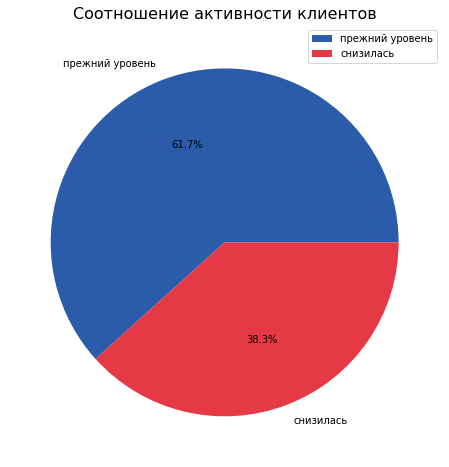

In [22]:
market_file_df.pivot_table(index='покупательская активность', values='id', aggfunc='count').plot(kind='pie',
                                                                                                subplots=True,
                                                                                                figsize=(8,8),
                                                                                                autopct='%1.1f%%')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Соотношение активности клиентов', fontsize=16);

Активность снижается у почти 40% пользователей.

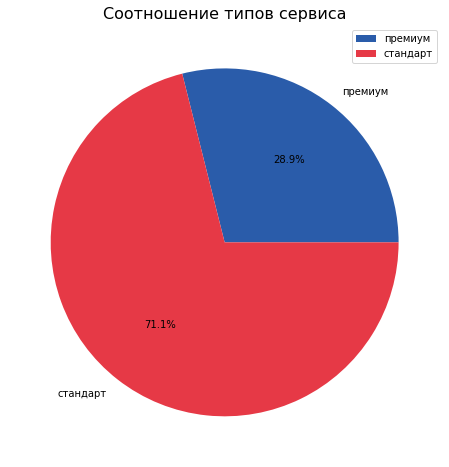

In [23]:
market_file_df.pivot_table(index='тип сервиса', values='id', aggfunc='count').plot(kind='pie',
                                                                                                subplots=True,
                                                                                                figsize=(8,8),
                                                                                                autopct='%1.1f%%')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Соотношение типов сервиса', fontsize=16);


Лишь 28.9% пользователей используют премиум подписку.

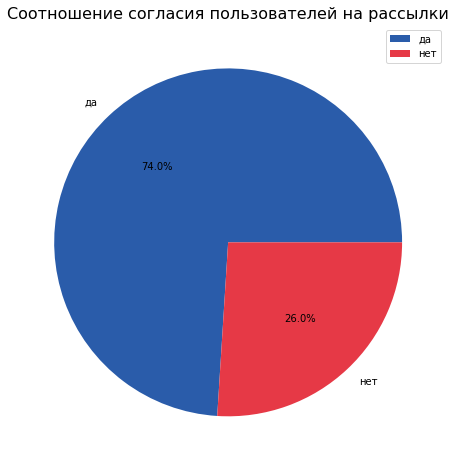

In [24]:
market_file_df.pivot_table(index='разрешить сообщать', values='id', aggfunc='count').plot(kind='pie',
                                                                                                subplots=True,
                                                                                                figsize=(8,8),
                                                                                                autopct='%1.1f%%')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Соотношение согласия пользователей на рассылки', fontsize=16);


Чуть больше четверти пользователей согласны получать уведомления от магазина.

In [25]:
market_file_df['маркет актив 6 мес'].describe()

count   1300.0000
mean       4.2538
std        1.0148
min        0.9000
25%        3.7000
50%        4.2000
75%        4.9000
max        6.6000
Name: маркет актив 6 мес, dtype: float64

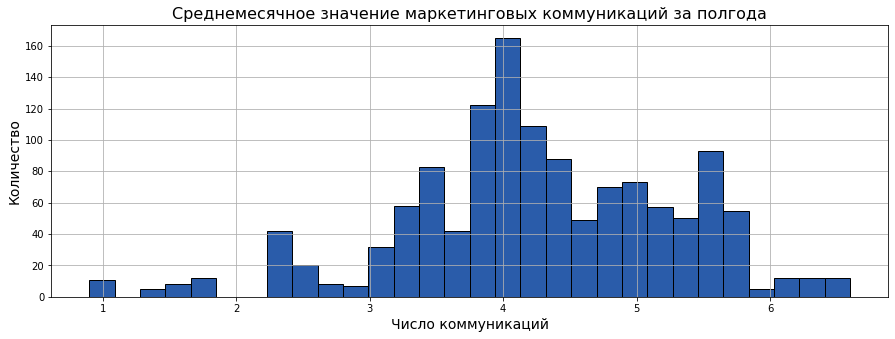

In [26]:
plt.figure(figsize=(15,5))
sns.histplot(market_file_df['маркет актив 6 мес'], bins=30, alpha=1)
plt.grid(True)
plt.title('Среднемесячное значение маркетинговых коммуникаций за полгода', fontsize=16)
plt.xlabel('Число коммуникаций', fontsize=14)
plt.ylabel('Количество', fontsize=14);

Основной диапазон количества коммуникаций от 3х до 5 за последние полгода. Самое частое - 4 коммуникации.

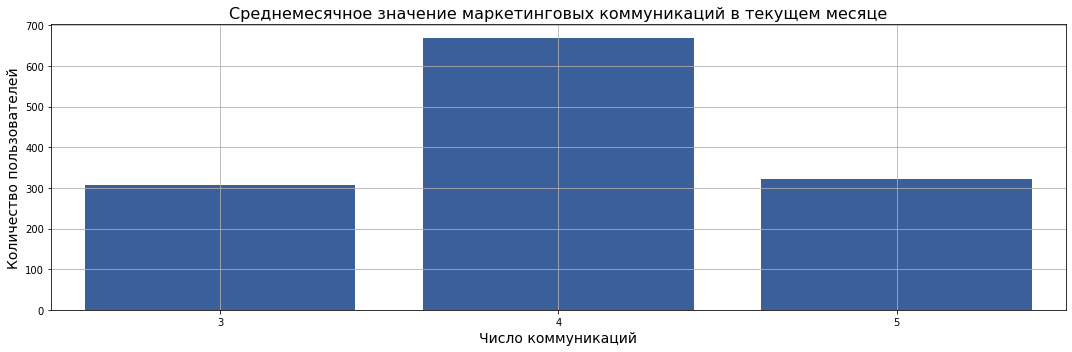

In [27]:
plt.figure(figsize=(15, 5))
sns.countplot(x='маркет актив тек мес', data=market_file_df, alpha=1)
plt.grid(True)
plt.title('Среднемесячное значение маркетинговых коммуникаций в текущем месяце', fontsize=16)
plt.xlabel('Число коммуникаций', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.tight_layout()
plt.show()


Среднемесячное количество коммуникаций так же в диапазоне от 3х до 5. С наиболее частым значением в 4 коммуникации.

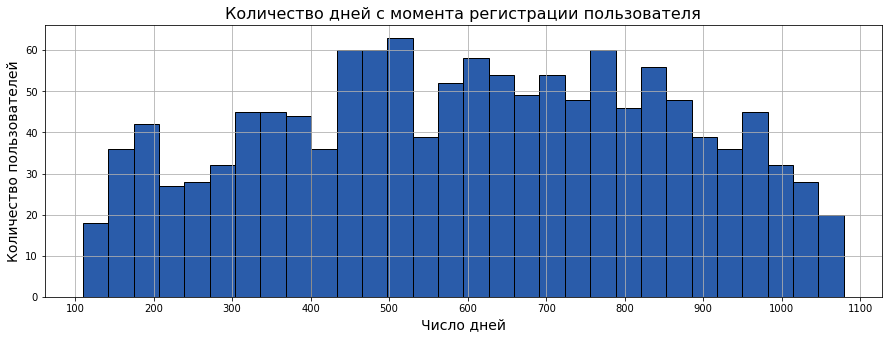

In [28]:
plt.figure(figsize=(15,5))
sns.histplot(market_file_df['длительность'], bins=30, alpha=1)
plt.grid(True)
plt.xticks(np.arange(100, 1200, 100))
plt.title('Количество дней с момента регистрации пользователя', fontsize=16)
plt.xlabel('Число дней', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14);

В датасете представлены, в основном, давно загерестрированные пользователи. От трех месяцев до трех лет. 

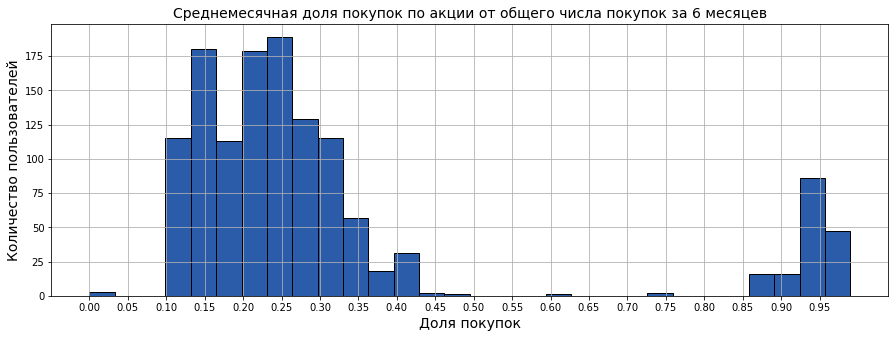

In [29]:
plt.figure(figsize=(15,5))
sns.histplot(market_file_df['акционные покупки'], bins=30, alpha=1)
plt.grid(True)
plt.xticks(np.arange(0, 1, 0.05))
plt.title('Среднемесячная доля покупок по акции от общего числа покупок за 6 месяцев', fontsize=14)
plt.xlabel('Доля покупок', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14);

Основная группа пользователей покупают товары, не руководствуясь только скидками. Однако присутвует 12.7% пользователей, чья доля покупок по акции составляет выше 85%.

In [30]:
print(f"""Процент покупателей с долей акционных покупок выше 85%: 
      {market_file_df.loc[market_file_df['акционные покупки'] > 0.85].shape[0] / len(market_file_df):.2%}""")

Процент покупателей с долей акционных покупок выше 85%: 
      12.69%


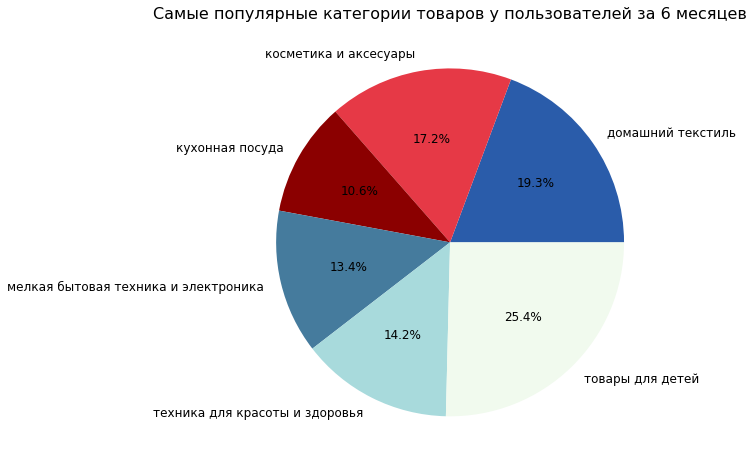

In [31]:
market_file_df.pivot_table(index='популярная категория', values='id', aggfunc='count').plot(kind='pie',
                                                                                            subplots=True,
                                                                                            figsize=(8,8),
                                                                                            autopct='%1.1f%%',
                                                                                            legend=False,
                                                                                           textprops={'fontsize': 12,
                                                                                                     'color': 'black'})
plt.xlabel(None)
plt.ylabel(None)
plt.title('Самые популярные категории товаров у пользователей за 6 месяцев', fontsize=16);


Преобладающие категории это товары для детей(25.4%) и домашний текстиль(19.3%)

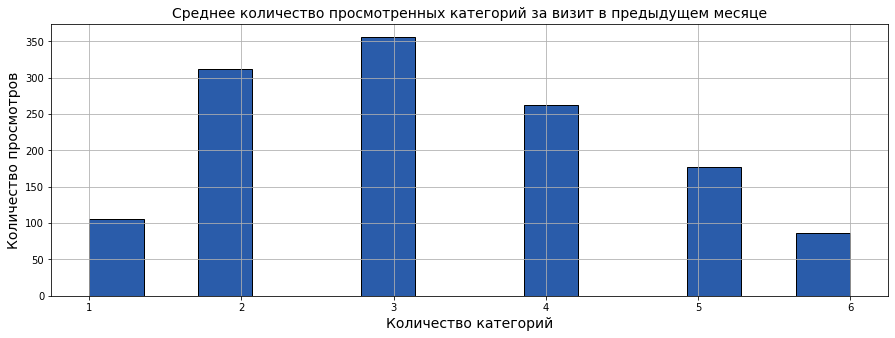

In [32]:
plt.figure(figsize=(15,5))
sns.histplot(market_file_df['средний просмотр категорий за визит'], alpha=1)
plt.grid(True)
plt.title('Среднее количество просмотренных категорий за визит в предыдущем месяце', fontsize=14)
plt.xlabel('Количество категорий', fontsize=14)
plt.xticks(np.arange(1,7,1))
plt.ylabel('Количество просмотров', fontsize=14);

В основном пользователи просматривают от 2х до 4х категорий. Просматривающие одну категорию пользователи, скорее всего, зашли на сайт за конкретным товаром.

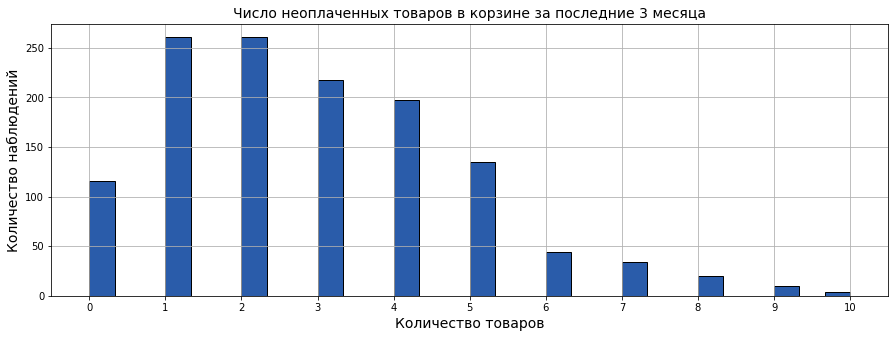

In [33]:
plt.figure(figsize=(15,5))
sns.histplot(market_file_df['неоплаченные продукты штук квартал'], bins=30, alpha=1)
plt.grid(True)
plt.title('Число неоплаченных товаров в корзине за последние 3 месяца', fontsize=14)
plt.xlabel('Количество товаров', fontsize=14)
plt.xticks(np.arange(0,11,1))
plt.ylabel('Количество наблюдений', fontsize=14);

Наиболее часто покупатели кладут в корзину 1-2 товара и оставляют их без оплаты. Возможно, ждут скидки или акции.

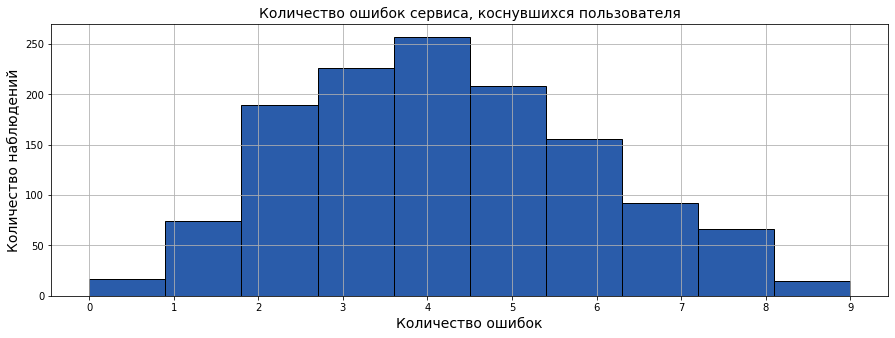

In [34]:
plt.figure(figsize=(15,5))
sns.histplot(market_file_df['ошибка сервиса'], bins=10, alpha=1)
plt.grid(True)
plt.xticks(np.arange(0,10,1))
plt.title('Количество ошибок сервиса, коснувшихся пользователя', fontsize=14)
plt.xlabel('Количество ошибок', fontsize=14)
plt.ylabel('Количество наблюдений', fontsize=14);

Самое частое наблюдение это четыре ошибки, коснувшихся пользователя. 

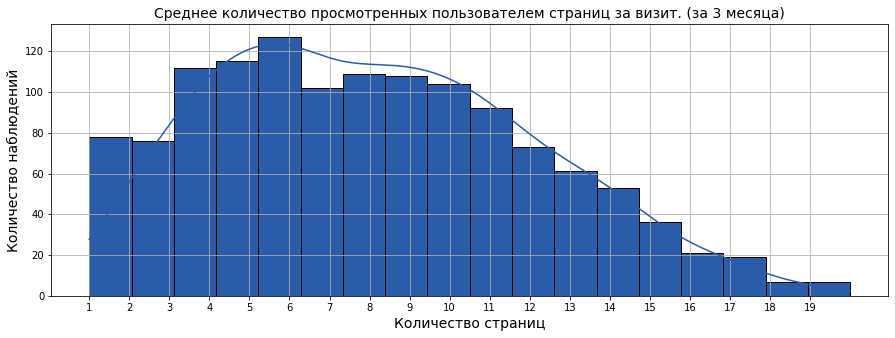

In [35]:
plt.figure(figsize=(15,5))
sns.histplot(market_file_df['страниц за визит'], kde=True, alpha=1)
plt.grid(True)
plt.title('Среднее количество просмотренных пользователем страниц за визит. (за 3 месяца)', fontsize=14)
plt.xticks(np.arange(1,20,1))
plt.xlabel('Количество страниц', fontsize=14)
plt.ylabel('Количество наблюдений', fontsize=14);

В основном пользователи просматривают от 3х до 6ти страниц

In [36]:
#Теперь изучим market_time_df

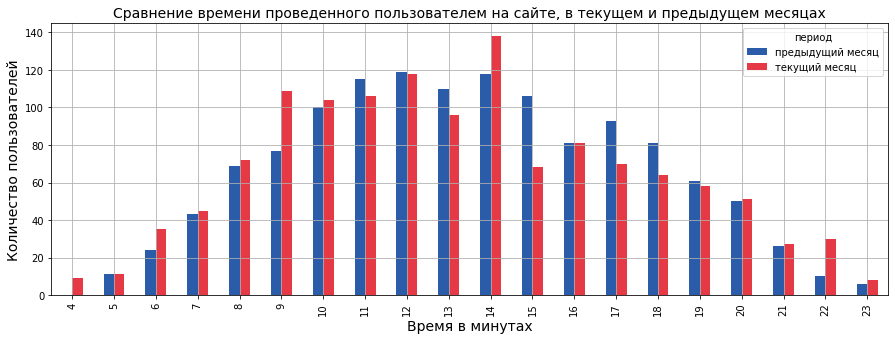

In [37]:
market_time_df.pivot_table(values='id', index='минут', columns='период', aggfunc='count').plot(kind='bar',
                                                                                               figsize=(15,5),
                                                                                               grid=True,
                                                                                              )
plt.title('Сравнение времени проведенного пользователем на сайте, в текущем и предыдущем месяцах', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.xlabel('Время в минутах', fontsize=14);

In [38]:
mean_minute = market_time_df.pivot_table(values='минут', index='id', columns='период', aggfunc='sum')
mean_minute.describe()

период  предыдущий месяц  текущий месяц
count          1300.0000      1300.0000
mean             13.4677        13.2046
std               3.9320         4.2206
min               5.0000         4.0000
25%              11.0000        10.0000
50%              13.0000        13.0000
75%              17.0000        16.0000
max              23.0000        23.0000

В среднем, пользователи за два месяца проводили на сайте примерно одинаковое количество минут.

In [39]:
# Изучим market_money_df
market_money_df.head()

id               период   выручка
0  215348  препредыдущий месяц    0.0000
1  215348        текущий месяц 3293.1000
2  215348     предыдущий месяц    0.0000
3  215349  препредыдущий месяц 4472.0000
4  215349        текущий месяц 4971.6000

In [40]:
market_money_df.describe()

id     выручка
count   3900.0000   3900.0000
mean  215997.5000   5025.6961
std      375.3257   1777.7041
min   215348.0000      0.0000
25%   215672.7500   4590.1500
50%   215997.5000   4957.5000
75%   216322.2500   5363.0000
max   216647.0000 106862.2000


 Название: money_df


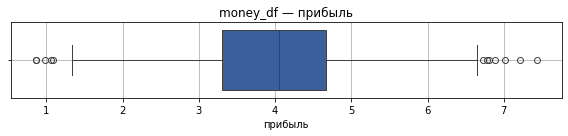


 Название: market_file_df


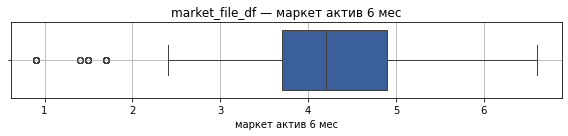

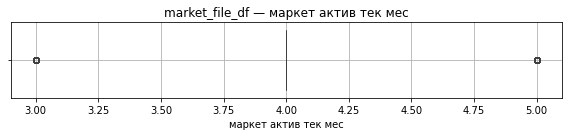

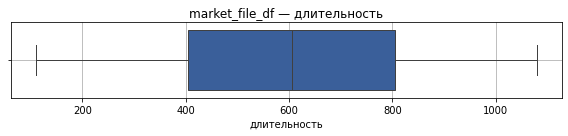

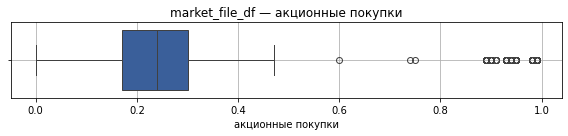

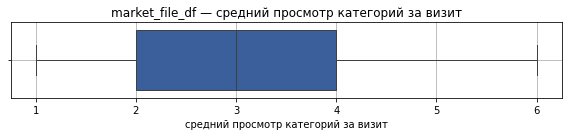

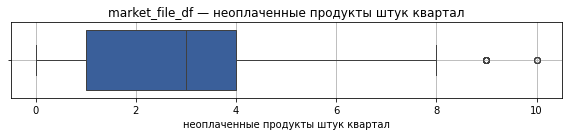

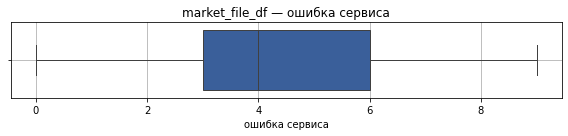

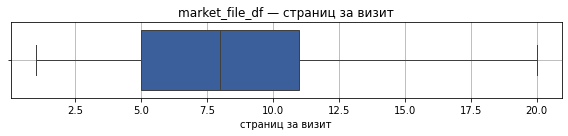


 Название: market_money_df


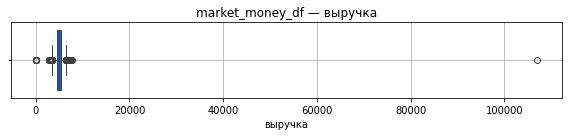


 Название: market_time_df


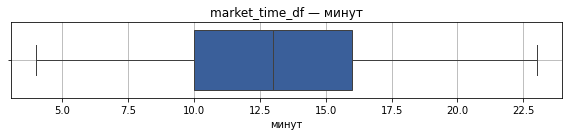

In [41]:
# Создаём словарь с названиями датафреймов, чтобы в цикле потом вывести название нужного дф.

dfs = {
    'money_df': money_df,
    'market_file_df': market_file_df,
    'market_money_df': market_money_df,
    'market_time_df': market_time_df
}

for df_name, df in dfs.items():
    print(f"\n Название: {df_name}")
    for column in df.select_dtypes(include='number').drop('id', axis=1).columns:
        plt.figure(figsize=(8, 2))
        sns.boxplot(x=df[column])
        plt.title(f'{df_name} — {column}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


* Наиболее выдающийся выброс в стобце "выручка" в market_money_df. 
* Выбросы в "акционные покупки" не считаю нужным изменять, так как на графике была видная явная группа пользователей, покупающих по акции.
* Остальные выбросы в данных так же считаю нужно оставить без изменения, так как они характеризуют поведение клиентов

In [42]:
# Удалим выброс в "выручка"

market_money_df = market_money_df.loc[market_money_df['выручка'] < 20000]

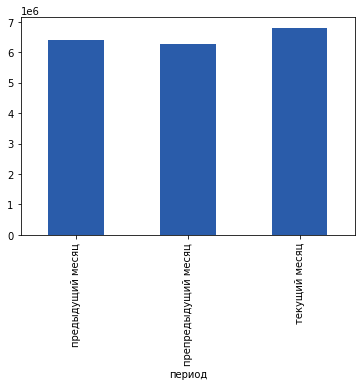

In [43]:
(market_money_df.loc[market_money_df['выручка'] != 0].pivot_table(values='выручка', index='период', aggfunc='sum')
.plot(kind='bar', legend=False));

In [44]:
market_money_df  = market_money_df[(market_money_df != 0).all(axis=1)].dropna()
market_money_df.describe()

id   выручка
count   3893.0000 3893.0000
mean  215998.6494 5007.2829
std      374.6817  679.7249
min   215348.0000 2758.7000
25%   215674.0000 4592.0000
50%   215999.0000 4959.0000
75%   216323.0000 5363.0000
max   216647.0000 7799.4000

In [45]:
market_money_df.loc[market_money_df['выручка'] == 0]

Empty DataFrame
Columns: [id, период, выручка]
Index: []

In [46]:
money_df.head()

id  прибыль
0  215348   0.9800
1  215349   4.1600
2  215350   3.1300
3  215351   4.8700
4  215352   4.2100

In [47]:
money_df.describe()

id   прибыль
count   1300.0000 1300.0000
mean  215997.5000    3.9966
std      375.4220    1.0137
min   215348.0000    0.8600
25%   215672.7500    3.3000
50%   215997.5000    4.0450
75%   216322.2500    4.6700
max   216647.0000    7.4300

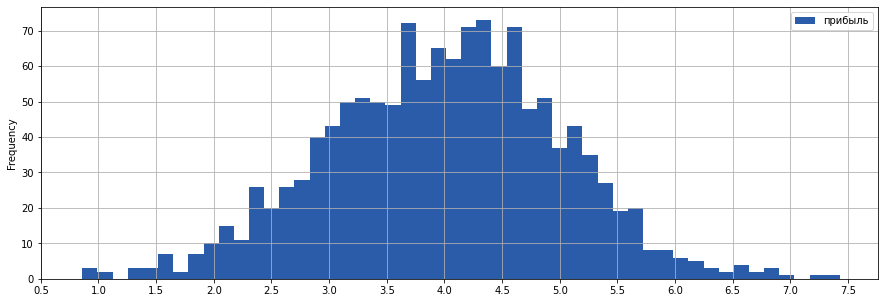

In [48]:
money_df.pivot_table(index='id', values='прибыль', aggfunc='sum').plot(kind='hist', bins=50, grid=True, figsize=(15,5))
plt.xticks(np.arange(0.5,8,0.5));

Данные в столбце прибыль имеют нормальное распределение

# Промежуточный вывод:

Снижение активности наблюдается у ~40% пользователей.

Лишь 28.9% используют премиум-подписку, а только четверть соглашаются на уведомления.

Частота коммуникаций за полгода в основном составляет 3–5 контактов, наиболее часто — 4. Такая же динамика наблюдается в среднемесячных значениях.

Большинство пользователей зарегистрированы давно (от 3 месяцев до 3 лет).

Хотя основная масса покупателей не ориентируется только на скидки, 12.7% пользователей совершают 85%+ покупок по акциям — это сегмент с повышенной чувствительностью к скидкам.

Ведущие категории: товары для детей (25.4%) и домашний текстиль (19.3%).

Основная масса просматривает 2–4 категории, реже — одну (что указывает на целевой заход).

В корзину чаще всего попадает 1–2 неоплаченных товара — возможное ожидание скидки.

Наиболее частая ошибка в системе — 4 сбоя на пользователя.

Большинство пользователей просматривают 3–6 страниц за визит.

Минуты, проведённые на сайте, в среднем одинаковы за последние 2 месяца.

В данных выявлены выбросы, но они отражают реальное поведение и сохраняются без удаления.

Выброс в столбце "выручка" удален.

Распределение прибыли — близкое к нормальному, что удобно для моделирования.

# Объединение данных

In [49]:
print(market_money_df.shape)
print(market_time_df.shape)
print(market_file_df.shape)

(3893, 3)
(2600, 3)
(1300, 13)


In [50]:
# Преобразуем таблицу с выручкой 
market_money_grouped = (
    market_money_df
    .pivot_table(index='id', columns='период', values='выручка')
    .add_prefix('выручка ')
    .reset_index()
)

# Преобразуем таблицу с временем 
market_time_grouped = (
    market_time_df
    .pivot_table(index='id', columns='период', values='минут')
    .add_prefix('минут ')
    .reset_index()
)

# Объединяем всё вместе 
market_full_df = (
    market_file_df
    .merge(market_money_grouped, on='id', how='left')
    .merge(market_time_grouped, on='id', how='left').dropna().reset_index(drop=True)
)


In [51]:
market_full_df.head()

id покупательская активность тип сервиса разрешить сообщать  \
0  215349                 снизилась     премиум                 да   
1  215350                 снизилась    стандарт                нет   
2  215351                 снизилась    стандарт                 да   
3  215352                 снизилась    стандарт                нет   
4  215353                 снизилась    стандарт                 да   

   маркет актив 6 мес  маркет актив тек мес  длительность  акционные покупки  \
0              4.4000                     4           819             0.7500   
1              4.9000                     3           539             0.1400   
2              3.2000                     5           896             0.9900   
3              5.1000                     3          1064             0.9400   
4              3.3000                     4           762             0.2600   

  популярная категория  средний просмотр категорий за визит  \
0     товары для детей                                    4   
1    домашний текстиль                                    5   
2     товары для детей                                    5   
3     товары для детей                                    3   
4    домашний текстиль                                    4   

   неоплаченные продукты штук квартал  ошибка сервиса  страниц за визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   выручка предыдущий месяц  выручка препредыдущий месяц  \
0                 5216.0000                    4472.0000   
1                 5457.5000                    4826.0000   
2                 6158.0000                    4793.0000   
3                 5807.5000                    4594.0000   
4                 4738.5000                    5124.0000   

   выручка текущий месяц  минут предыдущий месяц  минут текущий месяц  
0              4971.6000                 12.0000              10.0000  
1              5058.4000                  8.0000              13.0000  
2              6610.4000                 11.0000              13.0000  
3              5872.5000                  8.0000              11.0000  
4              5388.5000                 10.0000              10.0000

In [52]:
market_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская активность            1296 non-null   object 
 2   тип сервиса                          1296 non-null   object 
 3   разрешить сообщать                   1296 non-null   object 
 4   маркет актив 6 мес                   1296 non-null   float64
 5   маркет актив тек мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные покупки                    1296 non-null   float64
 8   популярная категория                 1296 non-null   object 
 9   средний просмотр категорий за визит  1296 non-null   int64  
 10  неоплаченные продукты штук квартал   1296 non-null   int64  
 11  ошибка сервиса                

In [53]:
print(f"Дубликатов в датафрейме: {(market_full_df.duplicated().sum()).sum()}")
print(f'Пропусков в датафрейме: {(market_full_df.isna().sum()).sum()}')

Дубликатов в датафрейме: 0
Пропусков в датафрейме: 0


# Промежуточный вывод:

На этом этапе были объеденены три датасета в один.

Объединение проводилось по ключу "id"

В итоговый датасет вошло 1262 строки и 18 колонок.

В итоговом датасете отсутствуют дубликаты и пропуски.


# Корреляционный анализ

In [105]:
INTERVAL_COLS = [
    "длительность", "акционные покупки", "средний просмотр категорий за визит",
    "неоплаченные продукты штук квартал", "ошибка сервиса", "страниц за визит",
    "выручка предыдущий месяц", "выручка препредыдущий месяц",
    "выручка текущий месяц", "минут предыдущий месяц", "минут текущий месяц"
]

phik_matrix = market_full_df.drop('id', axis=1).phik_matrix(interval_cols=INTERVAL_COLS)

<Figure size 720x720 with 0 Axes>

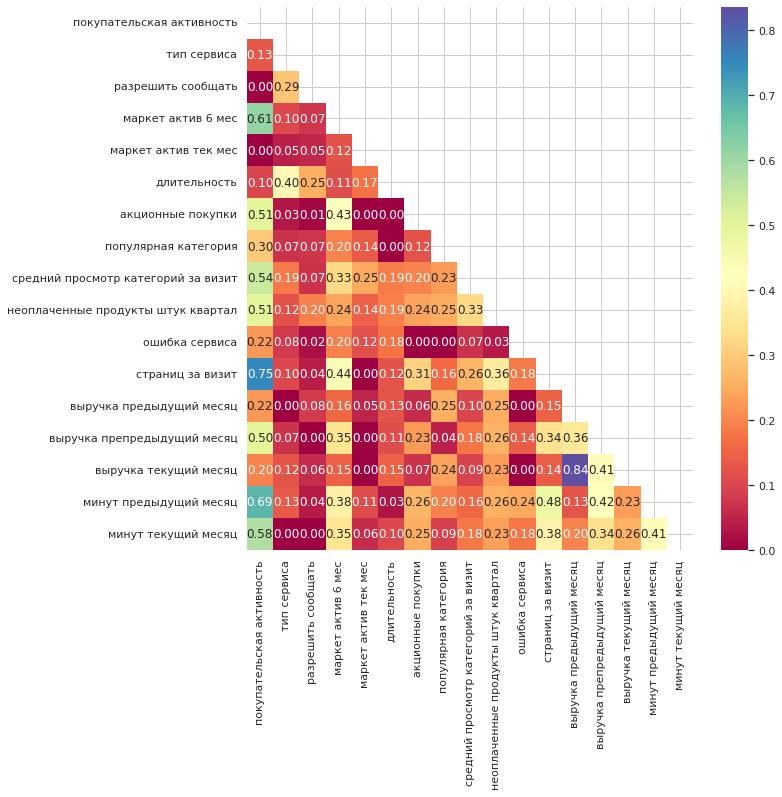

In [106]:
plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="Spectral", mask=mask);

In [107]:
# Создадим таблицу с признаками и значениями корреляции

phik_pairs = (
    phik_matrix
    .where(~mask)  # берём нижний треугольник
    .stack()  # убираем NaN, оставляем только уникальные пары
    .reset_index()
)

phik_pairs.columns = ['Признак 1', 'Признак 2', '$\\phi$ Корреляция']

# Сортируем по силе корреляции 
phik_pairs_sorted = phik_pairs.sort_values(by='$\\phi$ Корреляция', ascending=False)

phik_pairs_sorted.head(20)

Признак 1                           Признак 2  \
103                выручка текущий месяц            выручка предыдущий месяц   
55                      страниц за визит           покупательская активность   
105               минут предыдущий месяц           покупательская активность   
3                     маркет актив 6 мес           покупательская активность   
120                  минут текущий месяц           покупательская активность   
28   средний просмотр категорий за визит           покупательская активность   
15                     акционные покупки           покупательская активность   
36    неоплаченные продукты штук квартал           покупательская активность   
78           выручка препредыдущий месяц           покупательская активность   
116               минут предыдущий месяц                    страниц за визит   
58                      страниц за визит                  маркет актив 6 мес   
18                     акционные покупки                  маркет актив 6 мес   
118               минут предыдущий месяц         выручка препредыдущий месяц   
135                  минут текущий месяц              минут предыдущий месяц   
104                выручка текущий месяц         выручка препредыдущий месяц   
11                          длительность                         тип сервиса   
131                  минут текущий месяц                    страниц за визит   
108               минут предыдущий месяц                  маркет актив 6 мес   
64                      страниц за визит  неоплаченные продукты штук квартал   
90           выручка препредыдущий месяц            выручка предыдущий месяц   

     $\phi$ Корреляция  
103             0.8363  
55              0.7499  
105             0.6851  
3               0.6113  
120             0.5768  
28              0.5396  
15              0.5063  
36              0.5057  
78              0.4974  
116             0.4789  
58              0.4426  
18              0.4252  
118             0.4217  
135             0.4110  
104             0.4105  
11              0.4014  
131             0.3824  
108             0.3782  
64              0.3638  
90              0.3583

Исходя из результатов проведенного корреляционного анализа можно сделать следующие выводы:
У признаков "выручка текущий месяц" и "выручка предыдущий месяц" есть присутствует сильная корреляция, а так же линейная зависимость. 
"страниц за визит" и "покупательская активность" так же сильно коррелируют между собой
"минут предыдущий месяц" и "покупательская активность" тоже имеют высокую корреляцию. 


In [57]:
"""Для удобства работы создадим копию исходного датасета, 
так как в будущем предполагается работа с признаками, их удаление или модификация"""

market_copy = market_full_df.copy()

In [58]:
# Получаем все числовые признаки, исключая id и ряд признаков, по которым scatterplot неинформативный

num_features = market_copy.select_dtypes(include='number') \
                          .drop(columns=['id', 'маркет актив 6 мес', 'ошибка сервиса',
                                         'средний просмотр категорий за визит' ,'маркет актив тек мес']) \
                          .columns


feature_pairs = list(combinations(num_features, 2))
len(feature_pairs)

36

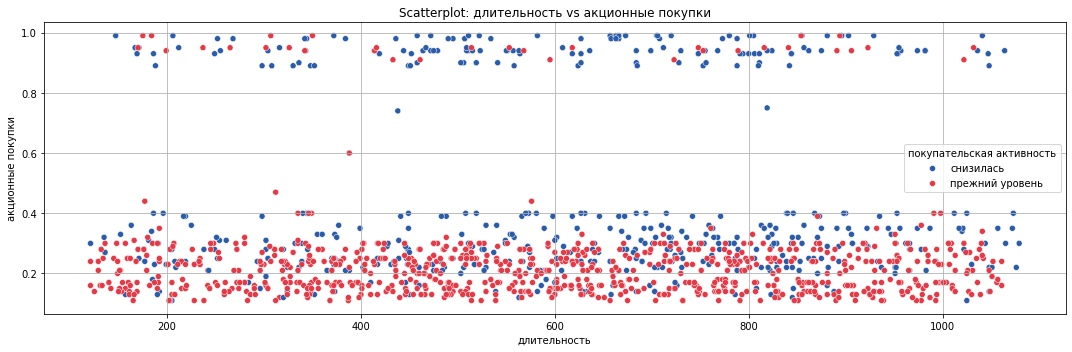

In [59]:
x_feat, y_feat = feature_pairs[0]
 
plt.figure(figsize=(15, 5))
sns.scatterplot(data=market_copy,
                x=x_feat,
                y=y_feat,
                hue='покупательская активность',
                alpha=1
               )
plt.title(f'Scatterplot: {x_feat} vs {y_feat}')
plt.grid(True)

plt.tight_layout()
plt.show()


Здесь нет четкой зависимости от времени регистрации и количества акционных покупок. Как и на гистограмме мы наблюдаем два кластера пользователей, один кластер, это те, кто совершает покупки в "обычном" режиме, и те, кто покупает, в основном, по акции. Но диаграмма рассеяния показывает, что среди "покупателей по акции" много пользователей с снижающейся покупательской активностью. 

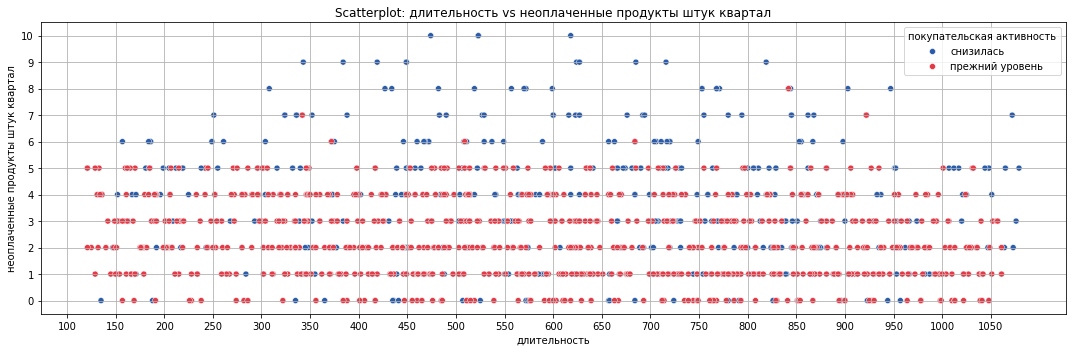

In [60]:
x_feat, y_feat = feature_pairs[1]
 
plt.figure(figsize=(15, 5))
sns.scatterplot(data=market_copy,
                x=x_feat,
                y=y_feat,
                hue='покупательская активность',
                alpha=1
               )
plt.title(f'Scatterplot: {x_feat} vs {y_feat}')
plt.grid(True)
plt.xticks(np.arange(100, 1100, 50))
plt.yticks(np.arange(0, 11, 1))
plt.tight_layout()
plt.show()

На данной диаграмме мы можем увидеть, что рост количества неоплаченных товаров начинается примерно со 150 дней после регистрации, начиная с 5 неоплаченных товаров в корзине мы снова видим, в основном, пользователей со снижающейся активностью

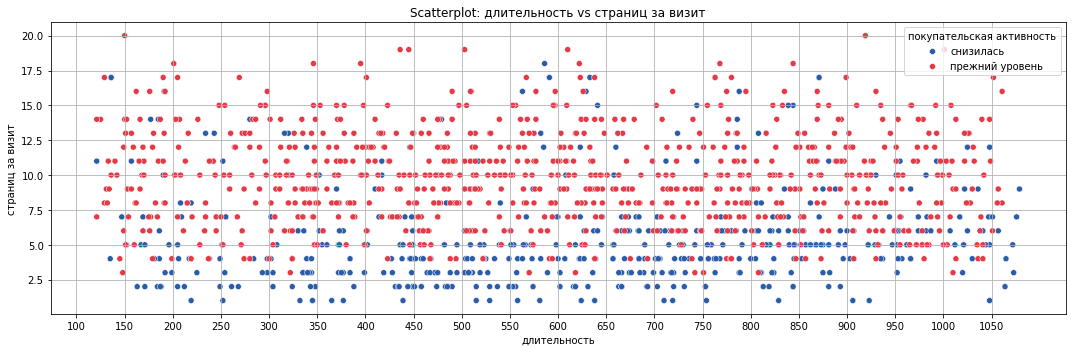

In [61]:
x_feat, y_feat = feature_pairs[2]
 
plt.figure(figsize=(15, 5))
sns.scatterplot(data=market_copy,
                x=x_feat,
                y=y_feat,
                hue='покупательская активность',
                alpha=1
               )
plt.title(f'Scatterplot: {x_feat} vs {y_feat}')
plt.grid(True)
plt.xticks(np.arange(100, 1100, 50))
plt.tight_layout()
plt.show()

Вне зависимости от длительности после регистрации пользователи, чья активность снижается, просматривают меньше страниц.

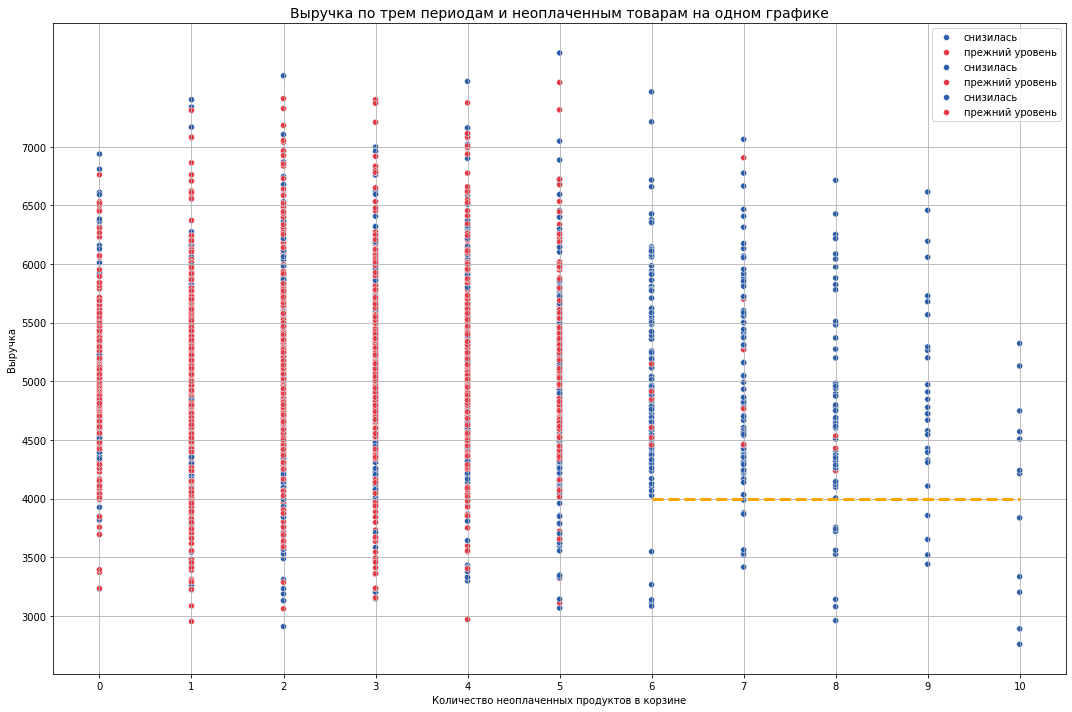

In [62]:
# Чтобы не рисовать графики по выручке за текущий, предыдущий и препредыдущий месяца, выведем их за раз, данные там похожи.

x_y_pairs = feature_pairs[16:19]
 
plt.figure(figsize=(15, 10))

for x_feat, y_feat in x_y_pairs:
    sns.scatterplot(
        data=market_copy,
        x=x_feat,
        y=y_feat,
        hue='покупательская активность',
        alpha=1,
        marker='o',

    )

plt.title("Выручка по трем периодам и неоплаченным товарам на одном графике", fontsize=14)
plt.grid(True)
plt.xlabel('Количество неоплаченных продуктов в корзине')
plt.ylabel('Выручка')
plt.tight_layout()
plt.xticks(np.arange(0,11,1))
plt.yticks(np.arange(2500,7500,500))
plt.legend()
plt.hlines(y=4000, xmin=6, xmax=10, color='orange', linestyle='--', linewidth=3)
plt.show()

Данная диаграмма показывает, что количество неоплаченных товаров в корзине не сильно влияет на выручку, это же мы можем увидеть в матрице корреляции, где средняя корреляция этих признаков будет ~0.263, Однако пользователи с 6 и более неоплаченными товарами в корзине чаще приносят магазину 4000 рублей и выше

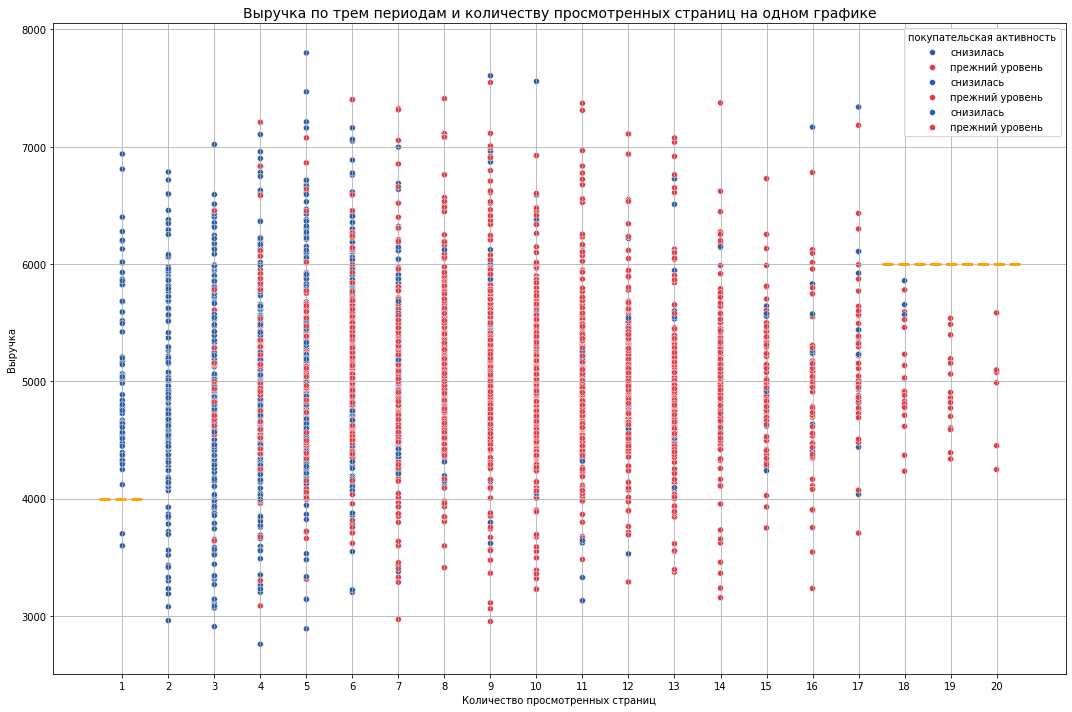

In [63]:
x_y_pairs = feature_pairs[21:24]
 
plt.figure(figsize=(15, 10))

for x_feat, y_feat in x_y_pairs:
    sns.scatterplot(
        data=market_copy,
        x=x_feat,
        y=y_feat,
        hue='покупательская активность',
        alpha=1,
        marker='o',

    )
plt.title(f'Scatterplot: {x_feat} vs {y_feat}')
plt.title("Выручка по трем периодам и количеству просмотренных страниц на одном графике", fontsize=14)
plt.grid(True)
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Выручка')
plt.grid(True)
plt.xticks(np.arange(1,21,1))
plt.hlines(y=4000, xmin=0.5, xmax=1.5, color='orange', linestyle='--', linewidth=3)
plt.hlines(y=6000, xmin=17.5, xmax=20.5, color='orange', linestyle='--', linewidth=3)
plt.tight_layout()
plt.show()

Количество просмотренных страниц не сильно влияет на выручку магазина. Но можно выделить два диапазона, первый -это пользователи, которые просматривают одну страницу, они чаще всего приносят магазину более 4000 рублей выручки. Второй это пользователи которые просматривают более 18 страниц. Они приносят магазину не более 6000 рублей выручки на протяжении 3 месяцев.
Первая группа, скорее всего это пользователи, которые ищут конкретный товар, вторая те, кто просто серфят по страница магазина.

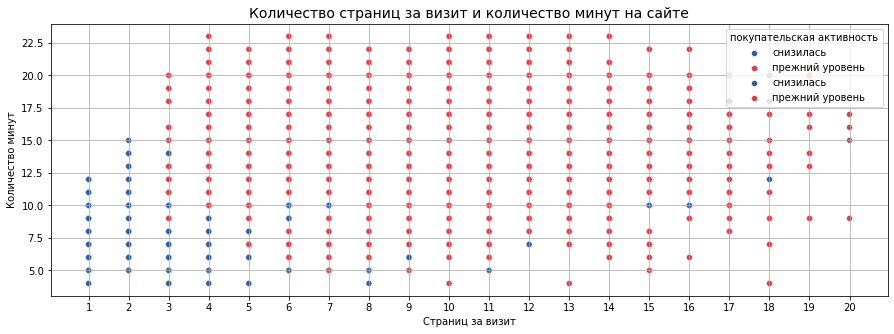

In [64]:
x_y_pairs = feature_pairs[24:26]
 
plt.figure(figsize=(15, 5))

for x_feat, y_feat in x_y_pairs:
    sns.scatterplot(
        data=market_copy,
        x=x_feat,
        y=y_feat,
        hue='покупательская активность',
        alpha=1,
        marker='o',

    )
plt.title(f'Scatterplot: {x_feat} vs {y_feat}')
plt.title("Количество страниц за визит и количество минут на сайте", fontsize=14)
plt.grid(True)
plt.xticks(np.arange(1,21,1))
plt.xlabel('Страниц за визит')
plt.ylabel('Количество минут')
plt.show()

В диапазоне от 1 до 4 страниц за визит время пребывания на сайте возрастает, затем оно распределяется равномерно

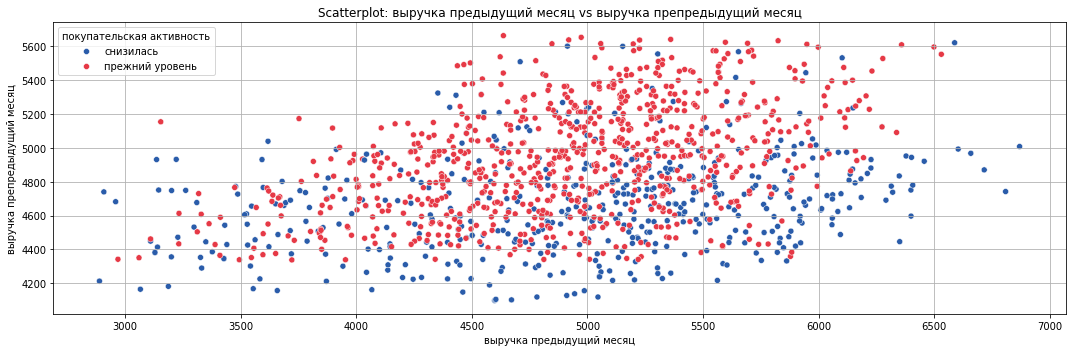

In [65]:
x_feat, y_feat = feature_pairs[26]
 
plt.figure(figsize=(15, 5))
sns.scatterplot(data=market_copy,
                x=x_feat,
                y=y_feat,
                hue='покупательская активность',
                alpha=1
               )
plt.title(f'Scatterplot: {x_feat} vs {y_feat}')
plt.grid(True)
plt.tight_layout()
plt.show()

Присутствует не ярко выраженная линейная зависимость. Так же можно отметить, что пользователи со снижающейся активностью приносили стабильно меньше выручки в предыдущие два месяца.

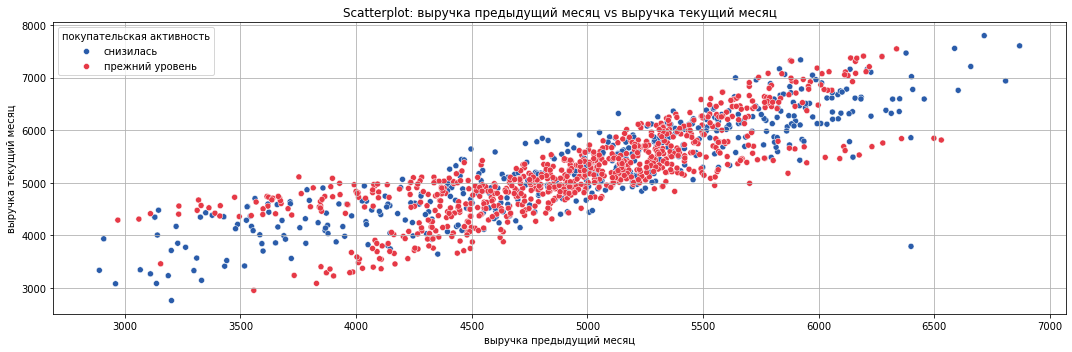

In [66]:
x_feat, y_feat = feature_pairs[27]
 
plt.figure(figsize=(15, 5))
sns.scatterplot(data=market_copy,
                x=x_feat,
                y=y_feat,
                hue='покупательская активность',
                alpha=1
               )
plt.title(f'Scatterplot: {x_feat} vs {y_feat}')
plt.grid(True)
plt.tight_layout()
plt.show()

Сильная линейная зависимость выручики в предыдущем месяце и выручки в текущем месяце.

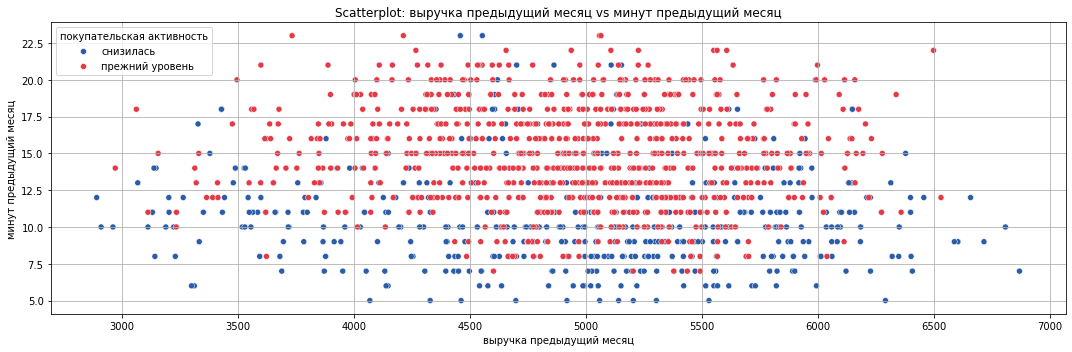

In [67]:
x_feat, y_feat = feature_pairs[28]
 
plt.figure(figsize=(15, 5))
sns.scatterplot(data=market_copy,
                x=x_feat,
                y=y_feat,
                hue='покупательская активность',
                alpha=1
               )
plt.title(f'Scatterplot: {x_feat} vs {y_feat}')
plt.grid(True)
plt.tight_layout()
plt.show()

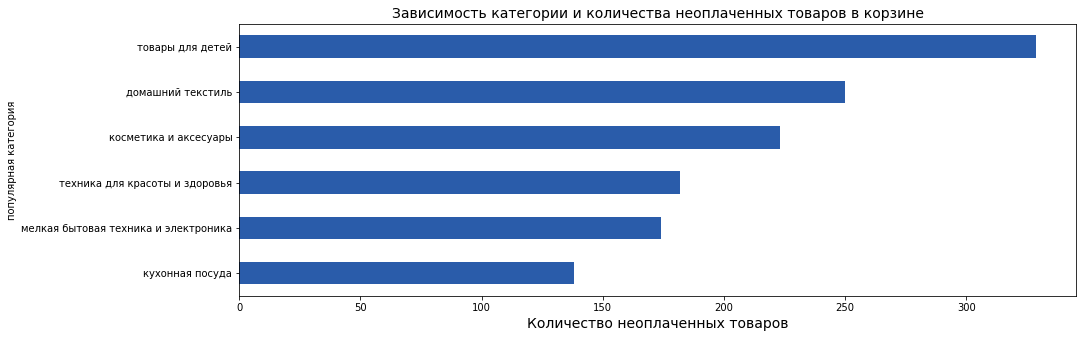

In [68]:

market_copy.pivot_table(values='неоплаченные продукты штук квартал',
                        index='популярная категория',
                        aggfunc='count').sort_values(['неоплаченные продукты штук квартал'],
                                                    ascending=True
                                                    ).plot(kind='barh', legend=False, figsize=(15,5))
plt.title('Зависимость категории и количества неоплаченных товаров в корзине', fontsize=14)
plt.xlabel('Количество неоплаченных товаров', fontsize=14);

Больше всего неоплаченных товаров из категории "товары для детей" на втором месте "домашний текстиль" и "косметика и аксессуары".

In [165]:
# Вычисляем дельту между выручками


market_copy['дельта выручки'] = market_copy['выручка текущий месяц'] - market_copy['выручка предыдущий месяц']

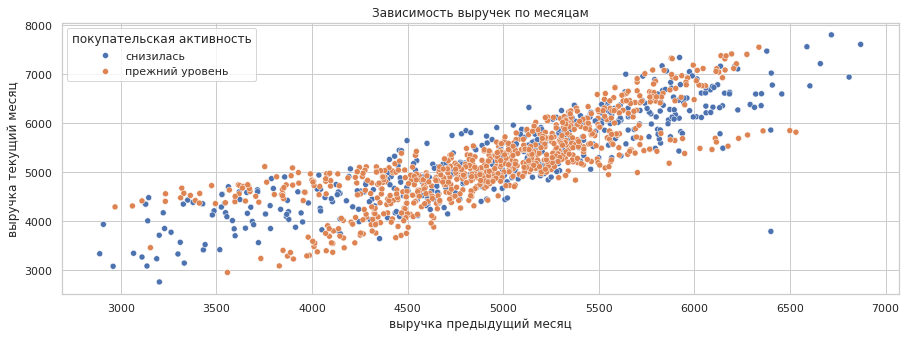

In [166]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=market_copy, x='выручка предыдущий месяц', y='выручка текущий месяц', hue='покупательская активность')
plt.title("Зависимость выручек по месяцам");

In [167]:
print(f"Коэф. корреляции: {(market_copy['выручка текущий месяц'].corr(market_copy['выручка предыдущий месяц'])).round(2)}")

Коэф. корреляции: 0.84


Между выручкой в предыдущем и текущем месяце наблюдается сильная линейная зависимость (r = 0.84).
Это говорит о том, что поведение клиента по расходам предсказуемо во времени, особенно для пользователей с "прежним уровнем активности".

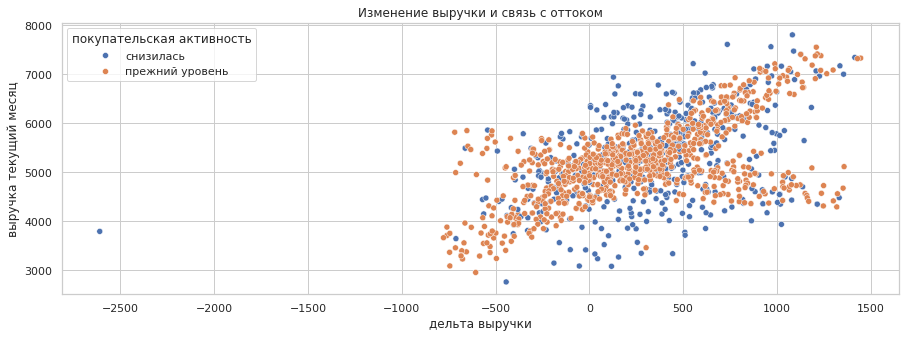

In [168]:

plt.figure(figsize=(15,5))
sns.scatterplot(data=market_copy, x='дельта выручки', y='выручка текущий месяц', hue='покупательская активность')
plt.title("Изменение выручки и связь с оттоком");


График показывает, что даже небольшое падение выручки может быть ранним сигналом снижения активности.
У клиентов с выручкой, сохраняющейся или растущей, вероятность оттока ниже.

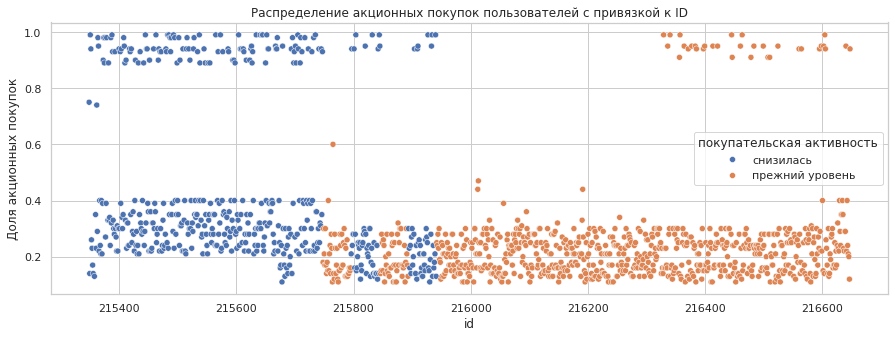

In [169]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=market_full_df, x='id', y='акционные покупки', hue='покупательская активность')
plt.title('Распределение акционных покупок пользователей с привязкой к ID')
plt.ylabel('Доля акционных покупок');

Ось Х, "ID" отсортированы в порядке создания, если предположить, что ID присваиваются последовательно каждому зарегистрированному пользователю. (по сути — хронология появления клиента)


У старой аудитории высокая доля акционных покупок часто сопровождается снижением активности, в то время как новые пользователи с тем же поведением остаются активными.

# Промежуточный вывод.


На основании корреляционного анализа были выявлены следующие ключевые зависимости между признаками:

Сильная линейная зависимость наблюдается между:

"выручка текущий месяц" и "выручка предыдущий месяц" (𝜙 = 0.82)

Это подтверждает, что клиенты, стабильно приносящие выручку, делают это из месяца в месяц.

Покупательская активность демонстрирует высокую корреляцию с рядом поведенческих и коммерческих признаков:

"страниц за визит" (𝜙 = 0.75)

"минут предыдущий месяц" (𝜙 = 0.69)

"минут текущий месяц" (𝜙 = 0.58)

"маркет актив 6 мес", "средний просмотр категорий за визит", "акционные покупки" — все в диапазоне 𝜙 ≈ 0.5–0.55
Это говорит о том, что снижение активности пользователя сопровождается уменьшением времени на сайте, количества просмотров и вовлечённости в акции.

Наличие неоплаченных товаров в корзине имеет умеренную корреляцию с выручкой (𝜙 ≈ 0.26), но при этом пользователи с 6 и более товарами чаще приносят выручку свыше 4000₽, что может быть полезно для таргетирования.

Взаимосвязь между "страницами за визит" и временем на сайте подтверждается умеренной корреляцией:

𝜙 = 0.48 между "минут предыдущий месяц" и "страниц за визит"

Это логично: больше страниц следовательно больше времени, но рост не линейный.

Интересная закономерность — пользователи, просматривающие 1 или >18 страниц, дают заметно разную выручку:

1 страница — часто ~4000₽ (целевая покупка)

18 страниц — в среднем до 6000₽ за 3 месяца 

Среди категорий с наибольшим числом неоплаченных товаров лидируют:

"товары для детей", затем "домашний текстиль" и "косметика и аксессуары"

Зависимость длительности после регистрации и снижения активности проявляется с ростом неоплаченных товаров после 150 дней с момента регистрации.

Анализ показал, что основные поведенческие признаки — страницы, минуты, вовлечённость в акции — существенно коррелируют с активностью и выручкой клиента. Это даёт основание использовать их как важные признаки для предсказания оттока. Также выявлены кластеры пользователей с высокой потенциальной ценностью, несмотря на признаки снижающейся активности.

# Построение модели машинного обучения

In [150]:
market_copy = market_full_df.copy()
market_copy.head()

id покупательская активность тип сервиса разрешить сообщать  \
0  215349                 снизилась     премиум                 да   
1  215350                 снизилась    стандарт                нет   
2  215351                 снизилась    стандарт                 да   
3  215352                 снизилась    стандарт                нет   
4  215353                 снизилась    стандарт                 да   

   маркет актив 6 мес  маркет актив тек мес  длительность  акционные покупки  \
0              4.4000                     4           819             0.7500   
1              4.9000                     3           539             0.1400   
2              3.2000                     5           896             0.9900   
3              5.1000                     3          1064             0.9400   
4              3.3000                     4           762             0.2600   

  популярная категория  средний просмотр категорий за визит  \
0     товары для детей                                    4   
1    домашний текстиль                                    5   
2     товары для детей                                    5   
3     товары для детей                                    3   
4    домашний текстиль                                    4   

   неоплаченные продукты штук квартал  ошибка сервиса  страниц за визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   выручка предыдущий месяц  выручка препредыдущий месяц  \
0                 5216.0000                    4472.0000   
1                 5457.5000                    4826.0000   
2                 6158.0000                    4793.0000   
3                 5807.5000                    4594.0000   
4                 4738.5000                    5124.0000   

   выручка текущий месяц  минут предыдущий месяц  минут текущий месяц  
0              4971.6000                 12.0000              10.0000  
1              5058.4000                  8.0000              13.0000  
2              6610.4000                 11.0000              13.0000  
3              5872.5000                  8.0000              11.0000  
4              5388.5000                 10.0000              10.0000

**работа с признаками**

In [151]:
# Уже после построения модели и анализа важности признаков было решено удалить этот столбец.

market_copy = market_copy.drop(['маркет актив 6 мес'], axis=1)

In [152]:
# Сделаем признак "акционные покупки" бинарным числовым на основе изученных ранее графиков.

market_copy['акционные покупки'] = market_copy['акционные покупки'].apply(lambda x: 1 if x > 0.85 else 0)

**Работа с моделью**

In [153]:
X = market_copy.drop(columns=['покупательская активность', 'id'])
y = market_copy['покупательская активность']

In [154]:
# Сделаем мапинг целевого признака, переформатировав в 0 и 1

y = y.map({'снизилась': 1, 'прежний уровень': 0})

In [155]:
print(y.value_counts())
y.value_counts(normalize=True)

покупательская активность
0    802
1    494
Name: count, dtype: int64


покупательская активность
0   0.6188
1   0.3812
Name: proportion, dtype: float64

Присутствует дисбаланс классов, который будет необходимо учесть при моделировании

In [156]:
# Поделим данные на тренировочные и тестовые

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

# Пайплайны

In [157]:
# Создадим списки с названиями столбцов для разных энкодеров

ohe_columns = ['разрешить сообщать', 'популярная категория']
num_columns = X_train.select_dtypes(include='number').columns
ord_columns = ['тип сервиса']

In [158]:
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

In [159]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['премиум', 'стандарт']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [160]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough')

In [161]:
pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier())  
])

scoring={'accuracy':'accuracy',
        'f1': make_scorer(f1_score),
        'roc_auc':'roc_auc',
        'precision' : 'precision',
        'recall': make_scorer(recall_score)}

# Параметры для перебора 
param_grid = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 10),
        'model__min_samples_split': [2, 3, 4],
        'model__min_samples_leaf' : range(2, 5)
    },
    # Три модели опорных векторов из-за разных наборов гиперпараметров таких как гамма и степень ядра.
    {
        'model': [SVC(kernel='linear', class_weight='balanced', probability=True, random_state=RANDOM_STATE)],
        'model__C': np.linspace(0.01, 5 , 100)
    },
    {
        'model': [SVC(kernel='rbf' ,class_weight='balanced', probability=True, random_state=RANDOM_STATE)],
        'model__C': np.linspace(0.01, 5 , 100),
        'model__gamma': ['scale', 'auto']
    },
    {
        'model': [SVC(kernel='poly', class_weight='balanced', probability=True, random_state=RANDOM_STATE)],
        'model__C': np.linspace(0.01, 5 , 100),
        'model__degree': [2, 6],
        'model__gamma': ['scale', 'auto']
    },
    # Две модели лог. регрессии из-за разного solver, чтобы небыло конфликта с гиперпараметром l1 ratio
    {
        'model' : [LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)],
        'model__solver' : ['saga'],
        'model__C': np.linspace(0.01, 3 , 100),
        'model__penalty' : ['elasticnet'],
        'model__l1_ratio': np.linspace(0,0.5,100)
    },
    {
        'model' : [LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)],
        'model__solver': ['liblinear'],
        'model__C' : np.linspace(0.01, 3 , 100),
        'model__penalty' : ['l1', 'l2']
        
    },
    {
        'model' : [KNeighborsClassifier()],
        'model__n_neighbors' : range(1,10)
    }
]


r_search = RandomizedSearchCV(
pipe,
param_distributions=param_grid,
n_iter=50,
scoring=scoring,
refit='recall',
verbose=3,
cv=5,
random_state=RANDOM_STATE,
n_jobs=-1)



In [162]:
%%time
# Обучение
r_search.fit(X_train, y_train)
# Результаты 
y_pred = r_search.predict(X_test)
y_proba = r_search.predict_proba(X_test)[:, 1]



print("Лучшая модель:\n", r_search.best_estimator_.named_steps['model'])
print("Лучший результат:", round(r_search.best_score_, 4))

print(classification_report(y_test, y_pred, zero_division=0))
print("recall метрика на тесте:", recall_score(y_test, y_pred, zero_division=0))
print('_________________________________________________')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END model=LogisticRegression(class_weight='balanced', random_state=666), model__C=1.7013131313131316, model__l1_ratio=0.04040404040404041, model__penalty=elasticnet, model__solver=saga; accuracy: (test=0.862) f1: (test=0.814) precision: (test=0.831) recall: (test=0.797) roc_auc: (test=0.903) total time=   0.1s
[CV 2/5] END model=LogisticRegression(class_weight='balanced', random_state=666), model__C=1.7013131313131316, model__l1_ratio=0.04040404040404041, model__penalty=elasticnet, model__solver=saga; accuracy: (test=0.872) f1: (test=0.843) precision: (test=0.798) recall: (test=0.893) roc_auc: (test=0.935) total time=   0.1s
[CV 3/5] END model=LogisticRegression(class_weight='balanced', random_state=666), model__C=1.7013131313131316, model__l1_ratio=0.04040404040404041, model__penalty=elasticnet, model__solver=saga; accuracy: (test=0.840) f1: (test=0.777) precision: (test=0.831) recall: (test=0.730) roc_auc: (test=0

In [183]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)  
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

recall_dummy = recall_score(y_test, y_pred_dummy)

print(f"Baseline recall: {recall_dummy:.2f}")




Baseline recall: 0.41


**Обоснование выбора метрики Recall:**

В данной задаче основная цель — распознать клиентов со снижением активности, то есть максимизировать количество корректно найденных объектов положительного класса (отток).
Метрика Recall показывает, какую долю из клиентов со снижением активности модель смогла правильно предсказать.


**Recall на тестовой выборке у модели получился ~0.79. Это означает, что модель распознает 79% объектов класса 1 (снижение активности) из всего количества объектов класса 1.**

Дополнительно пробовал локально запускать GridSearch около результатов лучшей модели, полученной в результате случайного поиска, но результата это не дало. 

Так же пробовал добавлять новые признаки на основе текущих, соеденять или удалять признаки, возводить малозначимые признаки в квадрат, пробовал перевод в бинарный  для некоторых признаков, но это тоже не дало результатов. А зачастую, только ухудшало качество модели.

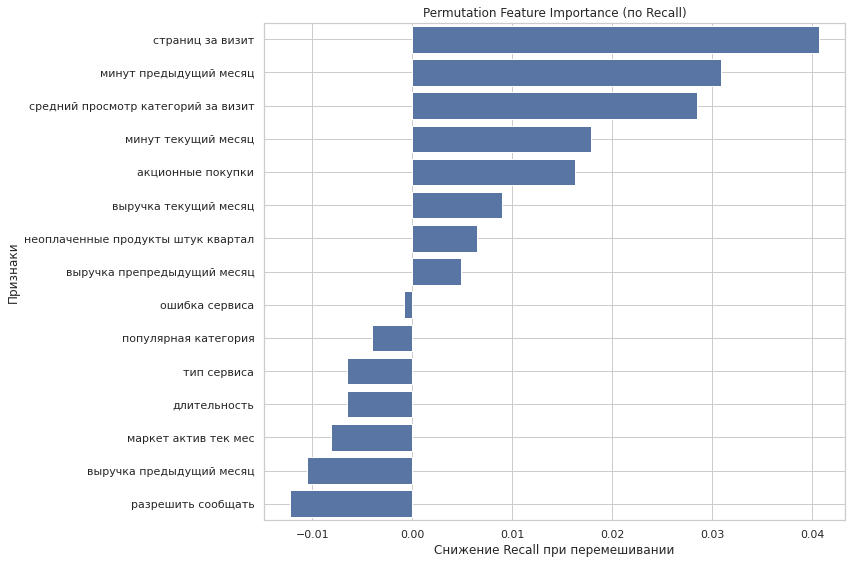

In [170]:
# Проведем анализ важности признаков при перестановке.

result = permutation_importance(
    estimator= r_search, 
    X=X_test,
    y=y_test,
    scoring='recall',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Визуализация
importances_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df,
    x='importance_mean',
    y='feature',
    orient='h'
)
plt.title('Permutation Feature Importance (по Recall)')
plt.xlabel('Снижение Recall при перемешивании')
plt.ylabel('Признаки')
plt.grid(True)
plt.tight_layout()
plt.show()


Сильного перекоса важности признаков при перестановке не наблюдается


In [171]:
low_value_features = importances_df.query('importance_mean <= 0')['feature'].tolist()
low_value_features

['ошибка сервиса',
 'популярная категория',
 'тип сервиса',
 'длительность',
 'маркет актив тек мес',
 'выручка предыдущий месяц',
 'разрешить сообщать']

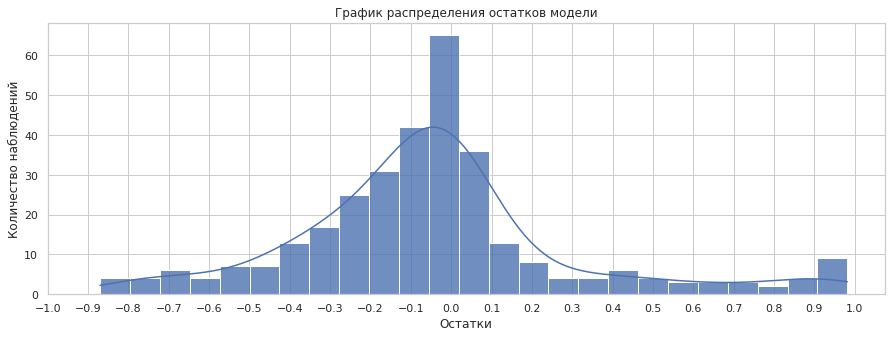

In [172]:
# посмотрим на распределение остатков модели
residuals = y_test - y_proba

plt.figure(figsize=(15,5))
sns.histplot(data=residuals, kde=True, alpha=0.8)
plt.xticks(np.arange(-1, 1.1, 0.1))
plt.title('График распределения остатков модели')
plt.xlabel('Остатки')
plt.ylabel('Количество наблюдений');

Много наблюдейний около нуля, модель в большинстве случаев достаточно точно определяет класс объекта.

График остатков смещен чуть влево, модель ошибается в сторону ложноположительного класса.

Присутствует подъем графика возле 1, модель иногда довольно уверенна в ошибочном предсказании

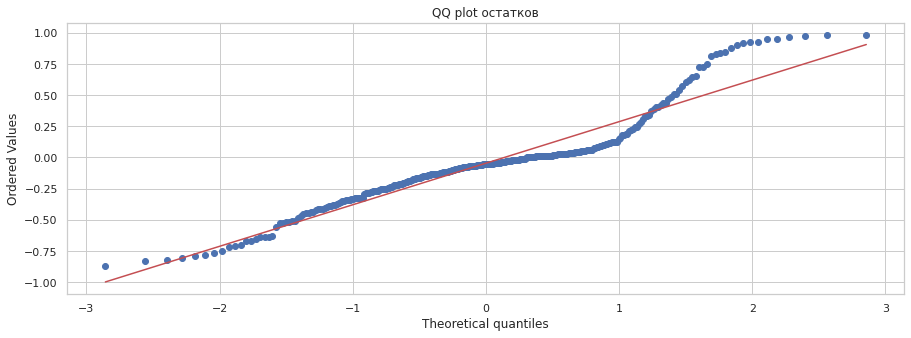

In [173]:
plt.figure(figsize=(15,5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ plot остатков")
plt.grid(True)
plt.show()

Распределение остатков не является строго нормальным — есть асимметрия и хвосты (особенно справа)

In [86]:
residuals.describe()

count   324.0000
mean     -0.0468
std       0.3448
min      -0.8703
25%      -0.2240
50%      -0.0540
75%       0.0407
max       0.9820
Name: покупательская активность, dtype: float64

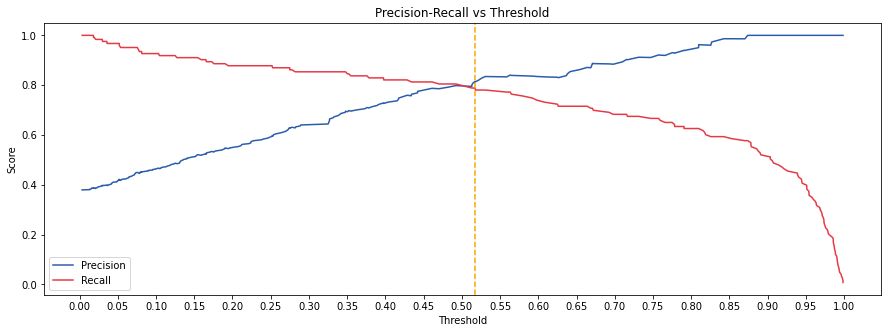

In [87]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(15,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.xticks(np.arange(0,1.05,0.05))
plt.axvline(x=0.517, linestyle='--', color='orange')
plt.legend()
plt.show()


Пересечение кривых precision и recall наблюдается при пороге 0.517, что близко к стандартному значению 0.5.
Изменение порога не даёт значимого прироста качества, а сильное снижение порога классификации приведет к росту ошибки первого рода. Поэтому использование дефолтного порога считаю обоснованным. 

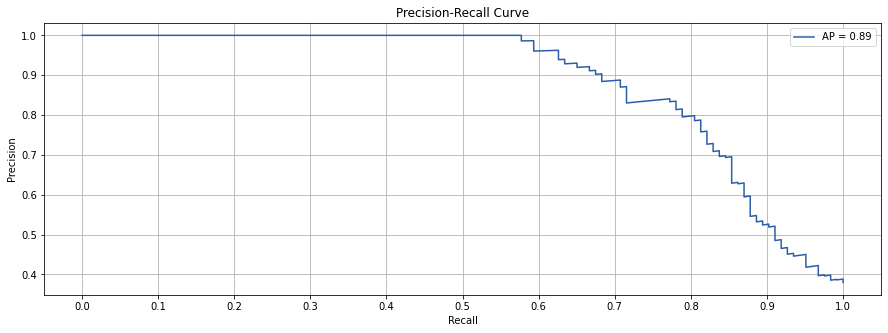

In [88]:


plt.figure(figsize=(15,5))
y_scores = y_proba
ap = average_precision_score(y_test, y_scores)

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xticks(np.arange(0,1.1,0.1))
plt.legend()
plt.grid(True)
plt.show()


Precision-Recall кривая демонстрирует стабильную и высокую точность на протяжении всего диапазона recall, с постепенным снижением precision лишь при очень высоких значениях полноты.
Это говорит о том, что модель сохраняет высокое качество предсказаний даже при попытке охватить максимальное количество положительных объектов.

Площадь под кривой (AP = 0.89) указывает на высокую способность модели уверенно распознавать положительный класс.

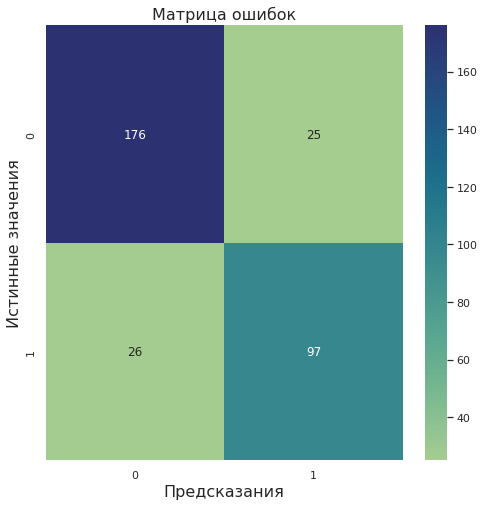

In [200]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title('Матрица ошибок', fontsize=16)
plt.xlabel('Предсказания', fontsize=16)
plt.ylabel('Истинные значения', fontsize=16);

модель немного ошибается в сторону ложноположительных срабатываний.

матрица ошибок подтверждает полученные ранее значения метрик (recall=0.84, presicion =0.81)

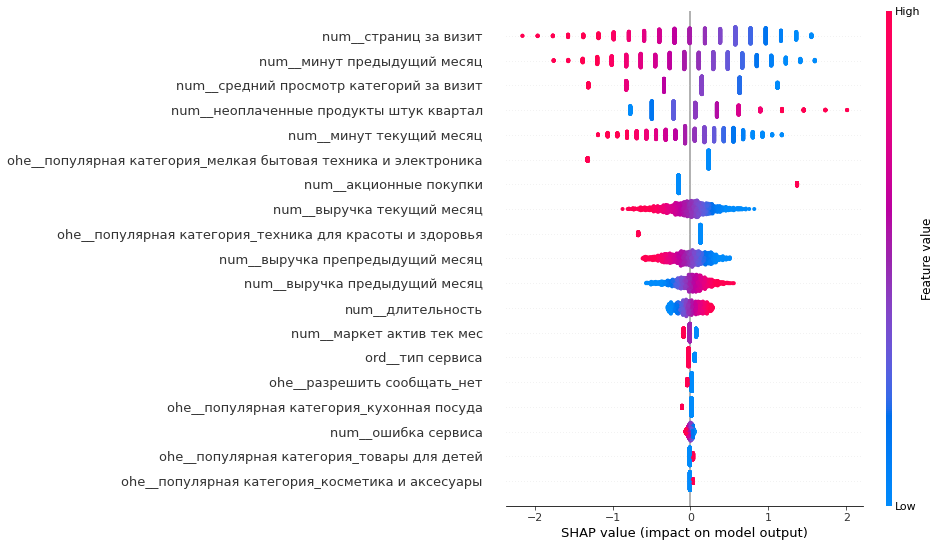

In [90]:
import shap

# Достаём модель и препроцессор из пайплайна
pipe = r_search.best_estimator_
model = pipe.named_steps['model']
preprocessor = pipe.named_steps['preprocessor']

# Преобразуем X через препроцессор
X_transformed = preprocessor.transform(X)  # без y
feature_names = preprocessor.get_feature_names_out()

# Строим SHAP
explainer = shap.LinearExplainer(model, X_transformed)
shap_values = explainer(X_transformed)

# Отрисовываем график
shap.plots.beeswarm(shap.Explanation(
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=X_transformed,
    feature_names=feature_names), max_display=len(feature_names))


Поведенческие признаки (время, страницы, покупки, выручка) — наиболее важны для модели.

Пользователи с меньшим вовлечением (мало страниц, минут, активности) чаще попадают в класс снижения активности.

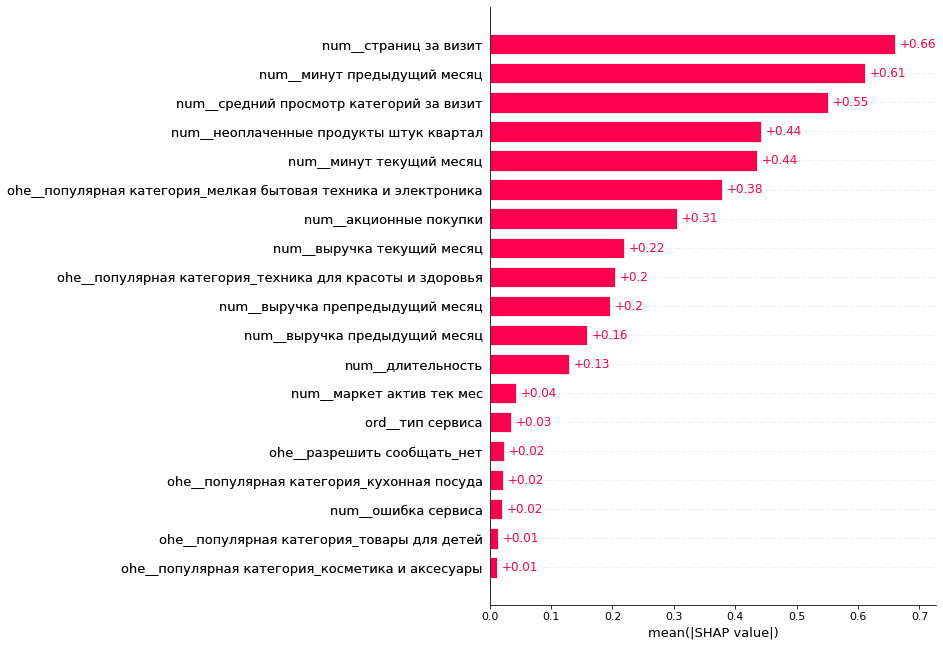

In [91]:
shap.plots.bar(
    shap.Explanation(
        values=shap_values.values,
        base_values=shap_values.base_values,
        data=X_transformed,
        feature_names=feature_names
    ),
    max_display=len(feature_names) 
)

Наиболее важным признаком при обучении модели стал "страниц за визит", он наиболее сильно характеризует снижение активности с точки зрения модели.

Так же в топ 5 попали признаки с количеством минут в предыдущем и текущем месяце.

Сравнимы по важности оказались признаки с количеством просмотренных категорий и количеством неоплаченных продуктов в корзине.

# Промежуточный вывод:

Лучшей моделью по метрике RECALL оказалась логистическая регрессия со следующими гиперпараметрами:

* **LogisticRegression**
  * C=np.float64(2.818787878787879)
  * class_weight='balanced',
  * l1_ratio=np.float64(0.3535353535353536)
  * penalty='elasticnet'
  * solver='saga'

Остатки модели распределены, в основном, около нуля.

**RECALL** на тестовой выборке =0.79. Модель распознает 79% объектов класса 1 (снижение активности) из всего количества объектов класса 1.


* Модель продемонстрировала уверенное качество классификации с высокой полнотой и точностью.Пересечение кривых precision и recall наблюдается при пороге 0.517, что практически совпадает со стандартным значением 0.5. Изменение порога не даёт прироста качества, поэтому использование дефолтного значения является обоснованным решением.

* Precision-Recall кривая демонстрирует стабильную и высокую точность на всём диапазоне recall, с её снижением только при попытке охватить максимум положительных объектов.Площадь под кривой — AP = 0.89 — подтверждает высокую способность модели уверенно распознавать целевой класс (снижение активности).

* Анализ матрицы ошибок показал, что модель небольшим образом склонна к ложноположительным срабатываниям, но в целом сохраняет высокий уровень точности и полноты.

* По результатам интерпретации с использованием SHAP, наибольший вклад в предсказания модели вносят поведенческие признаки:
  * страниц за визит — наиболее важный признак, отражающий снижение вовлечённости,
  * минуты в предыдущем и текущем месяце — характеризуют активность,
  * среднее количество просмотренных категорий за визит и неоплаченные товары — также входят в топ по важности.

**Таким образом, модель опирается на поведенческие паттерны пользователей, а снижение активности хорошо описывается метриками вовлечённости и покупок.**



# Сегментация покупателей.

In [92]:
# соединять данные будем из исходного дф, так как в копии мы удаляли и изменяли некоторые столбцы

market_segment = market_full_df.merge(money_df, on='id', how='inner')

In [93]:
# ознакомимся с полученным датафреймом и проверим размерности

market_segment.head()

id покупательская активность тип сервиса разрешить сообщать  \
0  215349                 снизилась     премиум                 да   
1  215350                 снизилась    стандарт                нет   
2  215351                 снизилась    стандарт                 да   
3  215352                 снизилась    стандарт                нет   
4  215353                 снизилась    стандарт                 да   

   маркет актив 6 мес  маркет актив тек мес  длительность  акционные покупки  \
0              4.4000                     4           819             0.7500   
1              4.9000                     3           539             0.1400   
2              3.2000                     5           896             0.9900   
3              5.1000                     3          1064             0.9400   
4              3.3000                     4           762             0.2600   

  популярная категория  средний просмотр категорий за визит  \
0     товары для детей                                    4   
1    домашний текстиль                                    5   
2     товары для детей                                    5   
3     товары для детей                                    3   
4    домашний текстиль                                    4   

   неоплаченные продукты штук квартал  ошибка сервиса  страниц за визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   выручка предыдущий месяц  выручка препредыдущий месяц  \
0                 5216.0000                    4472.0000   
1                 5457.5000                    4826.0000   
2                 6158.0000                    4793.0000   
3                 5807.5000                    4594.0000   
4                 4738.5000                    5124.0000   

   выручка текущий месяц  минут предыдущий месяц  минут текущий месяц  прибыль  
0              4971.6000                 12.0000              10.0000   4.1600  
1              5058.4000                  8.0000              13.0000   3.1300  
2              6610.4000                 11.0000              13.0000   4.8700  
3              5872.5000                  8.0000              11.0000   4.2100  
4              5388.5000                 10.0000              10.0000   3.9500

In [94]:
market_full_df.shape

(1296, 18)

In [95]:
print('Добавился один столбец, все в порядке.')
market_segment.shape

Добавился один столбец, все в порядке.


(1296, 19)

In [96]:
# Чтобы понять, какие клиенты являются наиболее прибыльными, выведем описательную статистику столбца "прибыль"

market_segment['прибыль'].describe()

count   1296.0000
mean       3.9977
std        1.0112
min        0.8600
25%        3.3000
50%        4.0450
75%        4.6700
max        7.4300
Name: прибыль, dtype: float64

In [97]:
# Добавим столбец с вероятностью отношения к классам,  полученным на этапе моделирования

market_segment['вероятность'] = r_search.best_estimator_.predict_proba(X)[:,1]

In [98]:
market_segment['предсказанный класс'] = r_search.best_estimator_.predict(X)

In [99]:
# Выделим целевую группу на основе прибыльности и вероятности снижения активности, предсказанной моделью.
# Возьмем 80% вероятности в качестве порога отношения к целевому сегменту.
# Порог по прибыльности это медиана столбца "прибыль"


market_segment['целевая группа'] = np.where(
    (market_segment['вероятность'] >= 0.8) & (market_segment['прибыль'] >= 4.06),
    'Целевая',
    'Остальные'
)

# Целевая и нецелевая
target_group = market_segment[market_segment['целевая группа'] == 'Целевая']
non_target_group = market_segment[market_segment['целевая группа'] == 'Остальные']

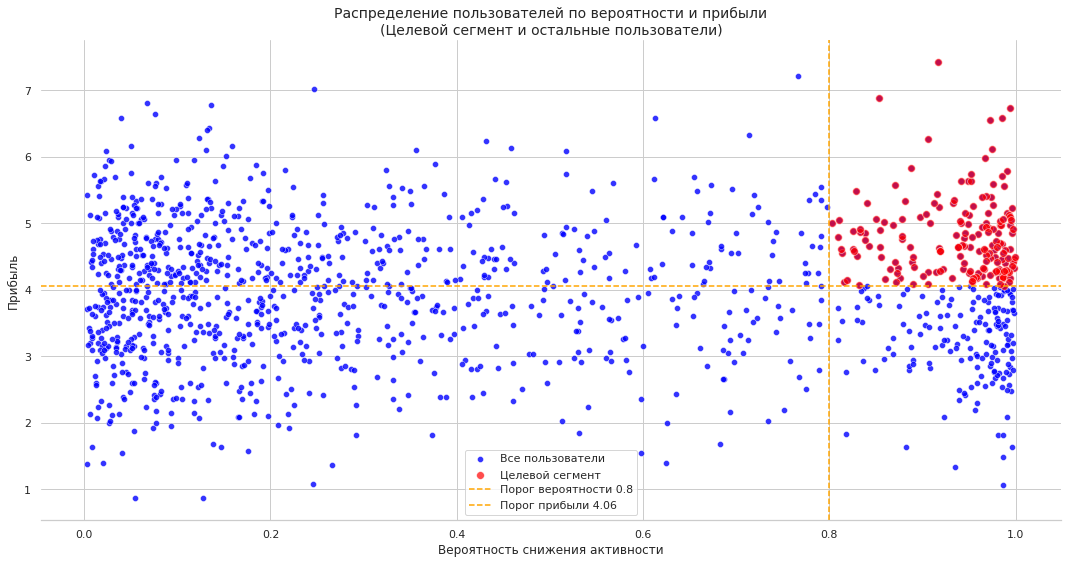

In [100]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid") 

# Основная точечная диаграмма
sns.scatterplot(
    data=market_segment,
    x='вероятность',
    y='прибыль',
    alpha=0.8,
    color='blue',
    label='Все пользователи'
)

# Целевая группа
sns.scatterplot(
    data=target_group,
    x='вероятность',
    y='прибыль',
    alpha=0.7,
    color='red',
    s=60, 
    label='Целевой сегмент'
)


# Вертикальные и горизонтальные границы сегментации
plt.axvline(x=0.8, color='orange', linestyle='--', label='Порог вероятности 0.8')
plt.axhline(y=4.06, color='orange', linestyle='--', label='Порог прибыли 4.06')


plt.title(
    'Распределение пользователей по вероятности и прибыли\n(Целевой сегмент и остальные пользователи)',
    fontsize=14,
)
plt.xlabel('Вероятность снижения активности', fontsize=12)
plt.ylabel('Прибыль', fontsize=12)
plt.legend(loc='best')
sns.despine(left=True)
plt.tight_layout()
plt.show()


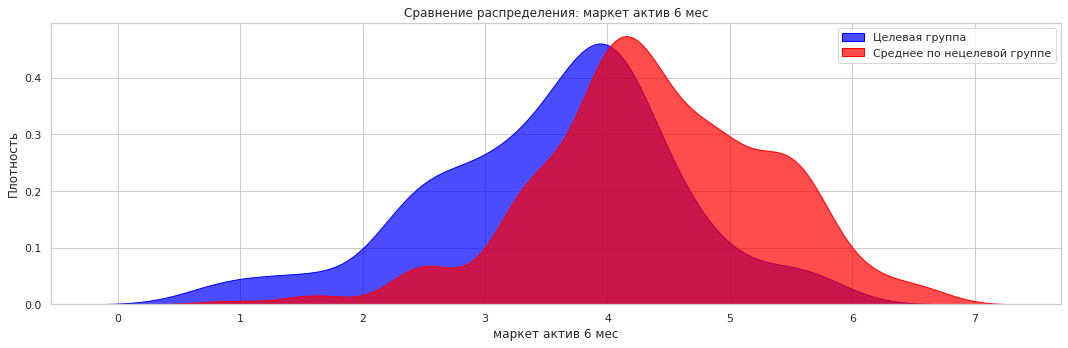

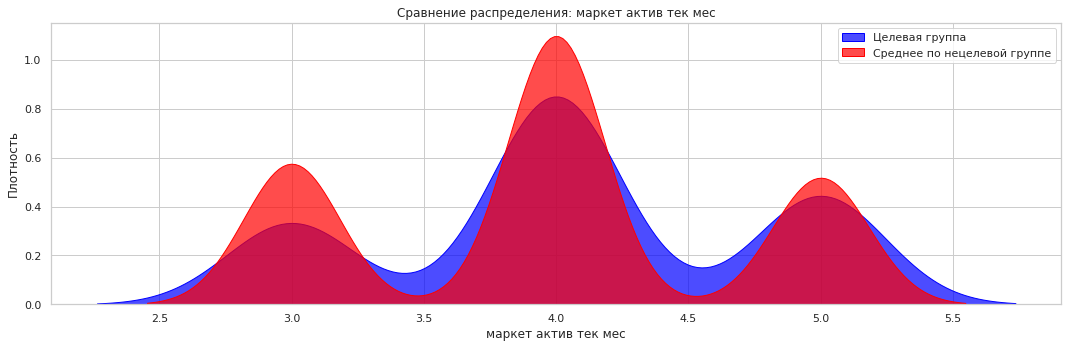

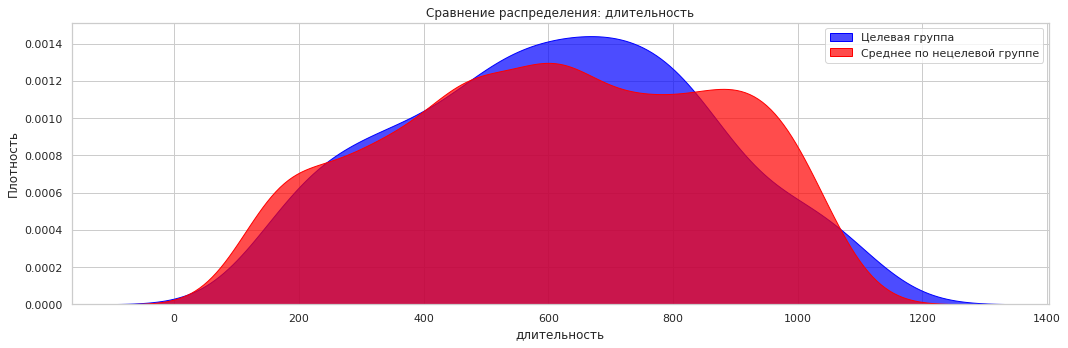

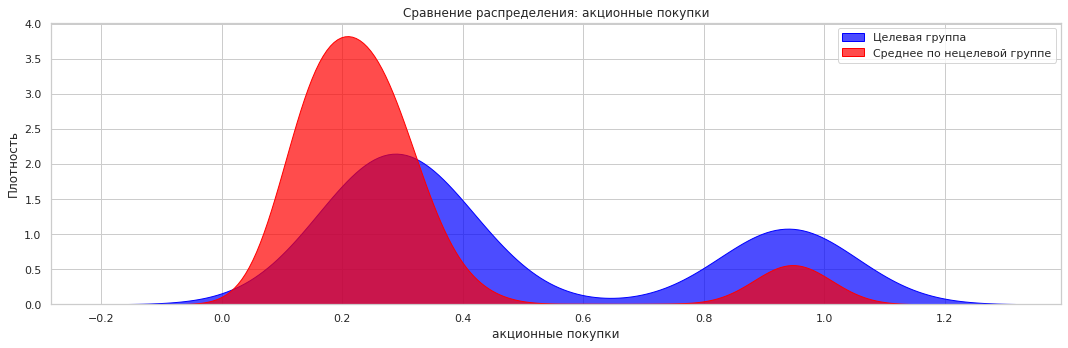

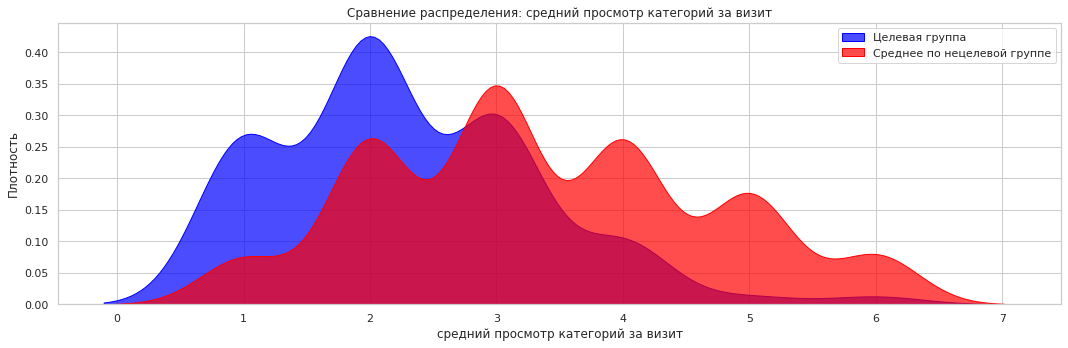

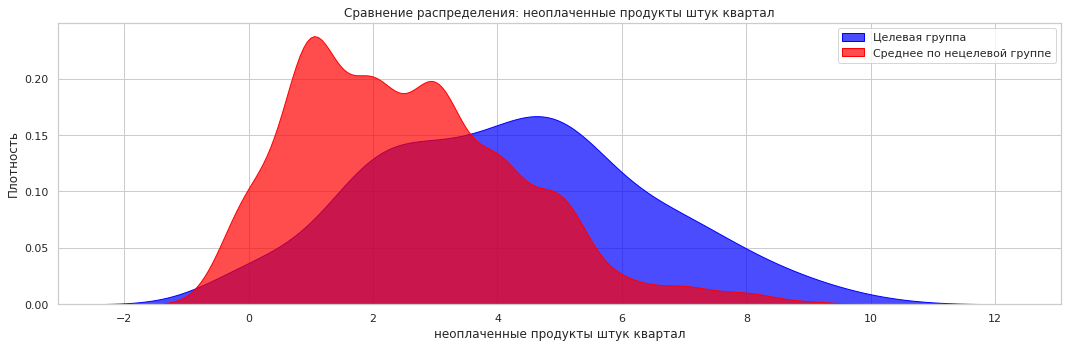

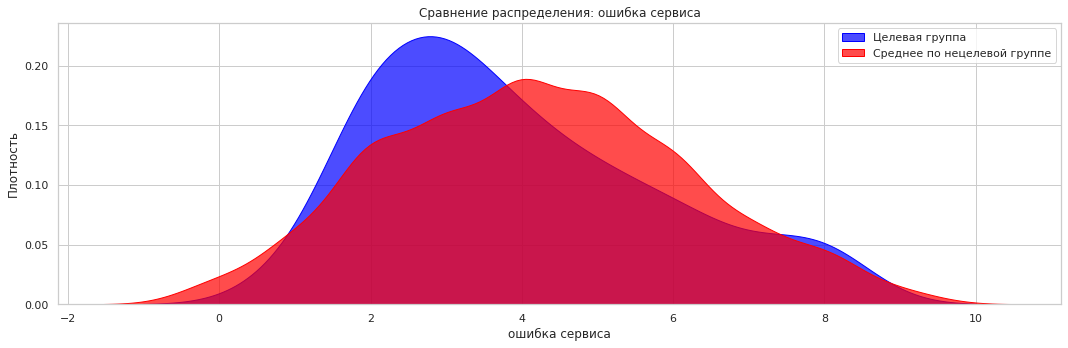

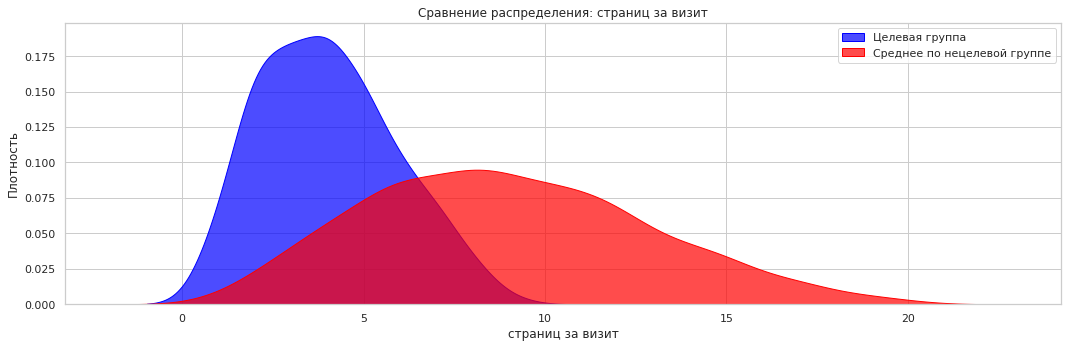

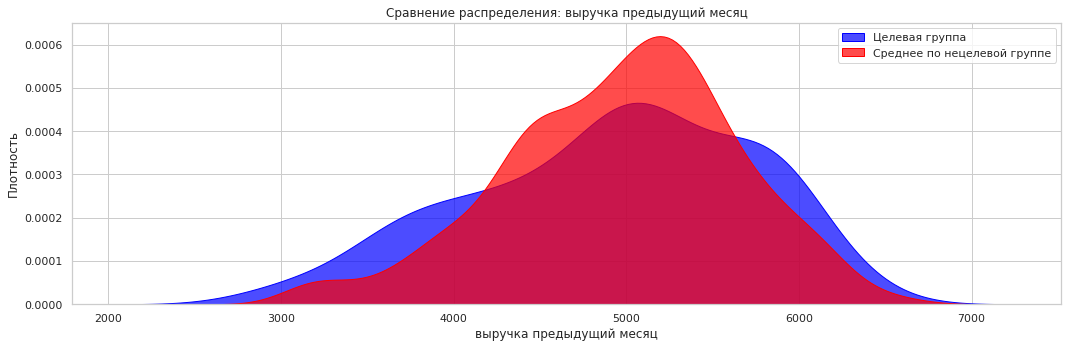

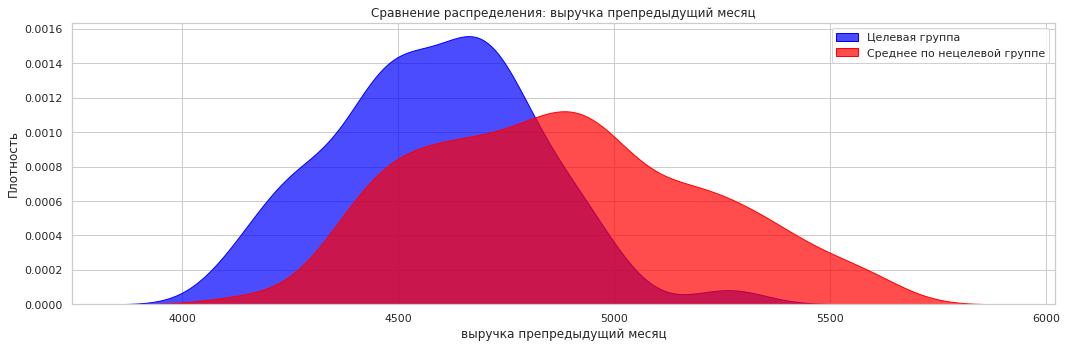

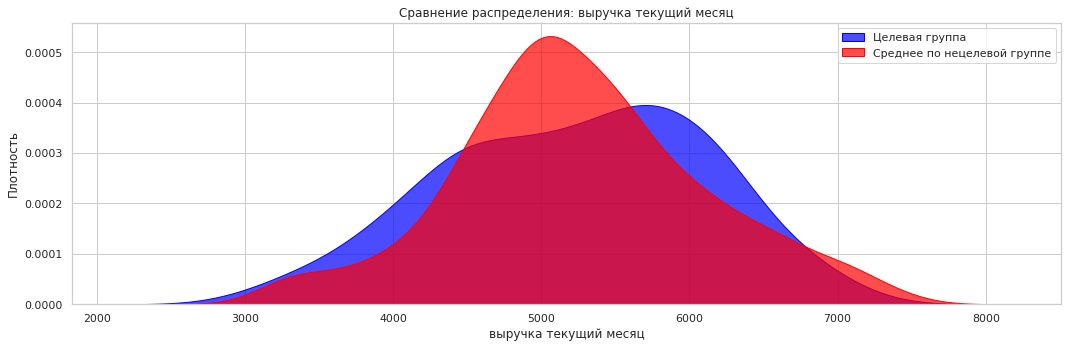

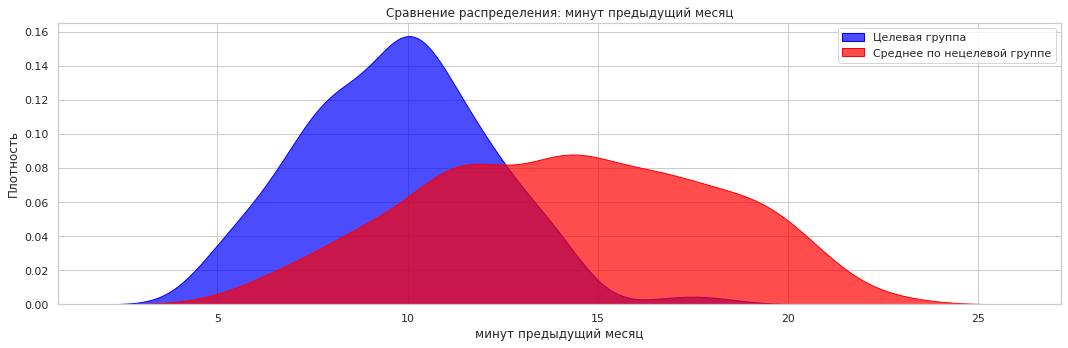

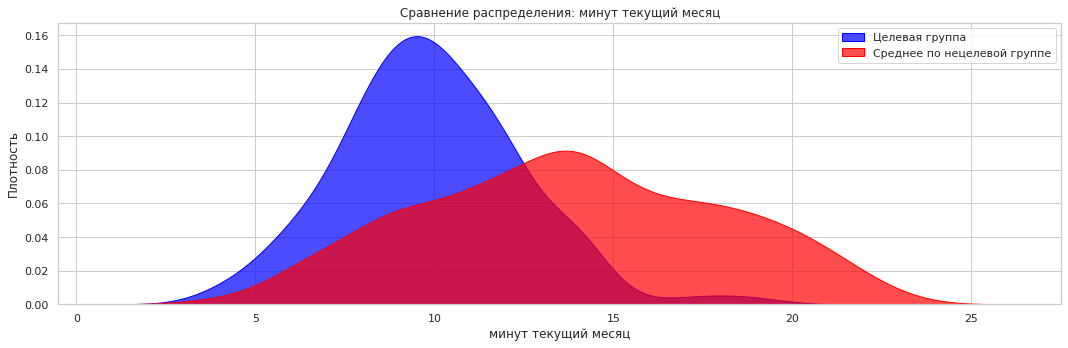

In [101]:
"""Ранее мы уже определили целевую и нецелевую группу. Сейчас я хочу посчитать распределения количественных признаков
у этих двух сегментов. Для сравнения хочу взять средние значения распределений у нецелевой группы.
В качестве графиков будут использованы графики плотности вероятности
"""

n_target = target_group.shape[0]
n_iterations = 5 
numeric_columns = market_segment.select_dtypes(include='number').drop(['id','вероятность', 
                                                                       'прибыль', 'предсказанный класс'], axis=1)\
.columns

# Создаём структуру для хранения значений по итерациям
non_target_samples_all = {col: [] for col in numeric_columns}

# Цикл по итерациям — накапливаем данные
for i in range(n_iterations):
    sample = non_target_group.sample(n=n_target, random_state=i)
    for col in numeric_columns:
        non_target_samples_all[col].append(sample[col].values)

# Построим средние распределения
for col in numeric_columns:
    plt.figure(figsize=(15,5))
    
    # Целевая группа
    sns.kdeplot(target_group[col], label='Целевая группа', fill=True,alpha=0.7, color='blue')
    

    # Собираем все строки из сэмплов
    averaged = np.concatenate(non_target_samples_all[col])

    # KDE по объединённой нецелевой выборке
    sns.kdeplot(averaged, label='Среднее по нецелевой группе', fill=True, alpha=0.7, color='red')

    
    plt.title(f'Сравнение распределения: {col}')
    plt.xlabel(col)
    plt.ylabel('Плотность')
    plt.legend()
    plt.tight_layout()
    plt.show()


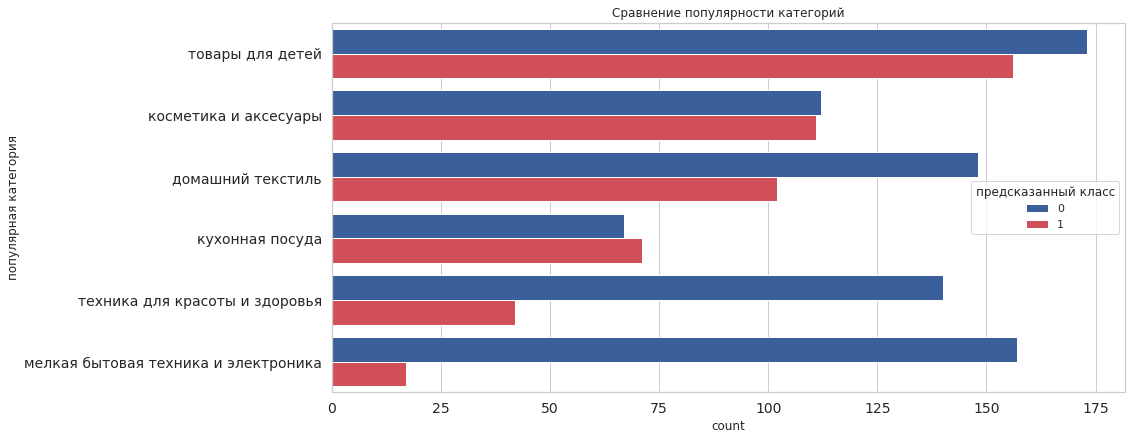

In [102]:
plt.figure(figsize=(15,6))
sns.countplot(
    data=pd.concat([target_group, non_target_group], axis=0),
    y='популярная категория',
    hue='предсказанный класс',
    orient='h',
    order=target_group['популярная категория'].value_counts().index, palette=custom_palette)
plt.tight_layout()
plt.title('Сравнение популярности категорий')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

* Из графиков видно, что количество маркетинговых коммуникаций за 6 месяцев и за текущий месяц у целевой группы меньше, чем среднее по нецелевой.

* График длительности говорит о том, что целевая группа, это не новые клиенты сервиса, а те, кто зарегистрирован достаточно давно.

* В целевую группу попали клиенты с большим количеством акционных покупок.

* Клиенты из целевой группы просматривают меньше категорий за визит, чем в среднем клиенты из нецелевой группы.

* У целевой группы больше неоплаченных покупок в корзине.

* Количество ошибок сервиса у клиентов из целевой группы даже ниже, чем у клиентов из нецелевой

* Клиенты из целевой группы в основном просматривают до 5 категорий за визит и редко серфят по сайту

* Выручка в предыдущий месяц у целевой группы смещена влево, выручка ниже у нецелевой группы пик правее и выручка выше

* В выручке в препердыдущий месяц ситуация схожа, но различия более выражены

* В текущем месяце пики выручки ближе друг к другу, но у целевой группы выручка в среднем так же ниже

* Распределение минут в предыдущем и текущем месяцах так же показывает снижение активности у целевой группы. Оба графика показывают нормальное распределение  в районе 10 минут, в то время как у активных пользователей эти значения более вытянуты и доходят до 25 минут

* Самыми популярными категориями у клиентов с предсказанным снижением активности являются "товары для детей" и "косметика и аксессуары", а самыми непопулярными "мелкая бытовая техника и электроника" и "техника для красоты и здоровья"


# Промежуточный вывод:

* **Анализ поведенческих признаков и выручки показывает, что целевая группа:**

  * менее вовлечена,

  * проводит меньше времени на платформе,

  * чаще не завершает покупки,

  * менее активно взаимодействует с категориями и маркетингом.
  
  * Самыми популярными категориями у клиентов с предсказанным снижением активности являются "товары для детей" и "косметика и аксессуары", а самыми непопулярными "мелкая бытовая техника и электроника" и "техника для красоты и здоровья"

**Эти особенности могут использоваться как ранние индикаторы снижения активности для построения предиктивной модели или персонализированного удержания.**

# Общий вывод:

* **Первичный анализ данных и предобработка**
  * Было загружено и проверено три основных датасета, содержащих поведенческие, финансовые и временные характеристики пользователей.

  * Данные не содержали пропусков, однако потребовалась ручная очистка:

  * Преобразование типов данных,

  * Обработка разделителей,

  * Устранение орфографических и стилистических ошибок,

  * Удаление и агрегация явных/неявных дубликатов.

  * Были выявлены и обработаны выбросы.

* **Исследовательский анализ данных**
  * Около 40% пользователей показывают признаки снижения активности.

  * Только 28.9% имеют премиум-подписку, и около 25% получают уведомления, что говорит о среднем уровне вовлечения.

  * Половина пользователей совершают 3–5 коммуникаций за полгода, чаще всего — 4.

  * Пользователи в основном зарегистрированы давно (3 мес – 3 года).

  * 12.7% пользователей совершают более 85% покупок по акции — сегмент, чувствительный к скидкам.

  * Наиболее популярные категории: товары для детей (25.4%) и домашний текстиль (19.3%).

  * Пользователи целевой группы:

  * просматривают меньше категорий,

  * проводят меньше времени на сайте,

  * совершают меньше покупок,

  * чаще оставляют неоплаченные товары в корзине.

  * При этом количество ошибок сервиса у них даже ниже, что исключает технические проблемы как причину оттока.

* **Корреляционный анализ**
  * Сильная корреляция между выручкой по месяцам (𝜙 = 0.82) — стабильность клиентской ценности.

  * Активность пользователей (страницы, минуты, категории, акции) — высоко коррелирует с выручкой и оттоком (𝜙 до 0.75).

  * Идентифицированы поведенческие кластеры (напр., пользователи с 1 или 18 страницами → разная выручка).

* **Построение модели**
    * В процессе моделирования был использован пайплайн с несколькими моделями:
      * DecisionTreeClassifier()
      * KNeighborsClassifier()
      * LogisticRegression()
      * SVC()

**В качестве метрики была выбрана Recall(полнота), потому что нам важно правильно спрогнозировать как можно большую долю клиентов со снижающейся активностью из всех клиентов.**

* **Лучшей по метрике Recall оказалась логистическая регрессия с гиперпараметрами:**

  * C=2.81, penalty=elasticnet, l1_ratio=0.35, solver=saga 

  * Recall = 0.84 на тесте: модель корректно распознаёт 79% пользователей со снижением активности.

  * Precision-Recall кривая и AP = 0.89 подтверждают высокую уверенность модели при классификации.

  * Остатки модели в основном близки к нулю, но присутствуют  хвосты (интерпретированы через Q-Q plot).

* **Интерпретация результатов**
    * По SHAP-важности ключевые признаки:

      * страниц за визит,

      * минуты в предыдущем и текущем месяце,

      * среднее количество категорий,

      * неоплаченные товары.

**Модель делает предсказания на основе поведенческих паттернов, а не случайных шумов.**

* **Рекомендации**
  * **Повысить вовлечённость через персонализированные коммуникации**
      * Клиенты из целевой группы взаимодействуют с сервисом реже, получают меньше уведомлений.

  * **Актуализировать предложения и акционные механики**
      * Целевая группа часто не завершает покупки, но показывает интерес к товарам и акциям.
  * **Фокус на ключевых категориях**
      * Самые популярные категории: товары для детей и косметика/аксессуары.


**Заключение:**

*Проведён комплексный анализ клиентского поведения с последующим построением предиктивной модели.
Выявлены ключевые поведенческие индикаторы снижения активности, успешно интерпретированы с помощью визуализации и SHAP.
Модель логистической регрессии показала высокую точность и полноту, что позволяет использовать её как основу для раннего прогнозирования оттока и персонализированного удержания пользователей.*


In [1]:
git init

SyntaxError: invalid syntax (2830201818.py, line 1)